# Fundamentos de Visão Computacional CMP197
## Trabalho de implementação 2
### Content based image retrieval (CBIR)

**Alunos**
- **João Vitor Rodrigues**: *243705*
- **Pedro Sidra de Freitas**: *000000*

O objetivo desse trabalho é o de explorar técnicas de visão computacional para a solução de um problema de busca de imagens por similaridade do conteúdo (CBIR). Para isso, seguindo a orientação do trabalho, é utilizado o *dataset* "The 216-shape database", contendo imagens binárias de diferentes categorias.

Foram implementadas diversas técnicas para a solução do problema apresentadas a seguir, junto da justificativa da sua escolha e análise crítica do resultado obtido

__Bibliotecas utilizadas__

In [1]:
from common import *
import mahotas
from scipy import spatial
import scipy.stats

import numpy.random

from functools import partial

import skimage
import torchvision.models as models
from PIL import Image

import torch
import clip

__Carregamento do dataset__

Para o carregamento do dataset, algumas funções auxiliares foram desenvolvidas (_common.py_). Elas realizam o dowload do dataset e já organizam as imagens em um dataframe estruturado.

In [2]:
db = load_db(download_tar("http://vision.lems.brown.edu/sites/default/files/216db.tar.gz"))

Extracting 216db.tar.gz to 216db
Removing 216db.tar.gz


__Funções Auxiliares para realização das queries__
- query: Recebe a imagem a ser usada como base de pesquisa, o tipo de descritor a ser utilizado para análise e a métrica a ser utilizada. Retorna as **n** imagens mais semelhantes encontradas.

- test_queries: Aplica o descritor especificado para todas as imagens (podendo ou não realizar uma transformação nessas).

- query_acc: Retorna a precisão da consulta realizada.

- query_accuracies: Retorna as precisões de múltiplas consultas realizadas.

- rand_rotate: Realiza a rotação e variação de escala indicadas no enunciado do trabalho

In [3]:
def query(image, descriptor, distance, top_n = 5, db=db):

    C = np.stack([descriptor(im) for im in db.image])

    desc = descriptor(image)
    dists = distance( desc, C )
    
    return db.iloc[np.argsort(dists)].head(n=top_n)


def test_queries(descriptor, distance, top_n=5, z_score_desc=False, i=None, transform=lambda im: im):

    # Get descriptors for all images
    # but apply `transform` first (a way to introduce noise)

    _db = db.copy()

    _db.image  = _db.image.apply(transform)
    
    _db["desc"]= [descriptor(im) for im in _db.image]

    if z_score_desc:
        D = np.stack(_db.desc.to_numpy())
        # Round to 10 digits to avoid unwanted variance from numerical precision
        D = scipy.stats.zscore(np.round(D,10), axis=0)
        # Fillna to make sure
        D = np.nan_to_num(D, nan=0)
        _db["desc"] = list(D)

    queries = []
    results=[]
    for clas in _db.clas.unique():

        if i is None:
            row = _db.query(f"clas=='{clas}'").sample(1).iloc[0]
        else:
            row = _db.query(f"clas=='{clas}'").iloc[i]


        C = np.stack(_db.desc.to_numpy())

        # desc = row.desc
        dists = distance( row.desc, C)

        queries.append(pd.DataFrame(data=[row]))#[["clas","image"]])
        results.append(_db.iloc[np.argsort(dists)].head(n=top_n))#[["clas","image"]])
    
    return queries, results

def query_acc(query, result):
    return np.sum(result.clas == query.clas.iloc[0])/len(result)

def query_accuracies(queries, results):
    res = pd.DataFrame()
    for q, r in zip(queries,results):
        res[f"{q.clas.iloc[0]}"]=pd.Series(query_acc(q,r))
    res.index.rename("Accuracy", inplace=True)
    return res

def rand_rotate(im, scale_range=(0.85,1.15), rotation_range=(-180,180)):
    h,w = im.shape
    s_low, s_high = scale_range
    r_low, r_high = rotation_range
    M = cv2.getRotationMatrix2D(
        # Keep center
        center=(w//2,h//2),
        # Use random ints for rotation (1 deg resolution is ok)
        angle=np.random.randint(low=r_low,high=r_high),
        # Use random float for scale
        scale=np.random.rand()*(s_high-s_low)+s_low,
    )
    return cv2.warpAffine(im, M, dsize=im.shape[::-1])

**Funções para apresentar os resultados e acurácia das consultas realizadas**

In [4]:
def show_query_results(queries, results):
    qDf = {}
    rDf = pd.DataFrame()
    for i, (q, r) in enumerate(zip(queries, results)):
        qDf[f"{q.clas.iloc[0]}"] = q.image.iloc[0]
        rDf[f"{q.clas.iloc[0]}"] = r.image.reset_index(drop=True)

    print("queries:")
    displayImages(pd.DataFrame(data=[qDf]))
    print("results:")
    displayImages(rDf)

def show_query_accuracy(queries, results):
    print("Accuracies:")
    acc = query_accuracies(queries,results)
    display(acc)
    print(f"Average along classes: {acc.transpose().mean().iloc[0]:.2f}")

**Funções definindo métricas de distância para os cálculos**

In [5]:
def log_transform(vec):
    return -1* np.copysign(1.0, vec) * np.log10(abs(vec))

def l1Dist(vec, dataset):
    return np.linalg.norm( vec.reshape(1,-1) - dataset , axis=-1, ord=1)

def l2Dist(vec, dataset):
    return np.linalg.norm( vec.reshape(1,-1) - dataset , axis=-1, ord=2)

def cosine_distance(vec, dataset):
    return [spatial.distance.cosine(vec, data) for data in dataset]

**Função para a regularização dos valores de uma imagem**

In [6]:
def regularize(image):

    A = np.vstack(np.where(image!=0)[::-1])
    center = np.mean(A,axis=-1)
    A = A.T - center
    u, s, vt = np.linalg.svd(A)

    if np.linalg.det(vt) < 0:
        vt[0,:] = vt[0,:]*-1

    r= vt
    c = center
    dsize = (250,250)

    center_d = (dsize[0]/2, dsize[1]/2)
    W = np.zeros((2,3))
    W[:2,:2] = r 
    W[:2,2] = -r@c  + center_d

    im2 = cv2.warpAffine(image, W, dsize=dsize)
    return im2

## Hu Moments

Um dos descritores de forma/contorno mais notáveis são os momentos de Hu  (_Hu Moments_).
A partir da extração do contorno de um objeto, podemos extrair o vetor de _features_ do objeto e então realizar a comparação entre o vetor da imagem de consulta e as do banco de dados. 
Nesse exercício, já temos a silhueta dos objetos diretamente nas imagens do _dataset_ .
 

### Hu moments direto

A implementação foi realizada diretamente utilizando a biblioteca do OpenCV.

In [7]:
def hu_moments(im):
    im = 255*(im!=0).astype(np.uint8)
    h=cv2.moments(im)

    return cv2.HuMoments(h).flatten()    

Visualizando uma consulta simples de uma imagem do banco de dados

In [8]:
displayDf(query(db.iloc[6].image, descriptor=hu_moments, distance=l2Dist, top_n=5))

,clas,num,image
6,bird,15,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAIIAAACCCAAAAACvaE8hAAACyUlEQVR4AcXBAZLbOBAEwar/P7pvfY6wyOWAwlBAKFO+Tr5Ovk6+TgbCX7Kb1MKLbCWVcCI7SSH8IhvJVbiQfeQiFGQb+SWUZBs5CwOyixyFIdlFjsKYbCIv4Y5sIi/hjmwiB0FiDBXZQyqhIHtILVzJFlILV7KFDIQL2UJGwm+yhYyEC9lBRsKF7CAj4UJ2kJFwITvISLiQHWQkXMgOMhKuZAMZCAXZQAZCQTaQgVCR9WQgFGQDGQgVWU9qoSTryUAoyXIyEEqynNTCgKwmtTAgq0ktDMhqUgsjspiUwpAsJqUwJmtJKYzJWlIKN2QpKYUbspSUwh1ZSSrhlqwkpXBLFpJKuCcLSSnck3WkEt6RZaQS3pJVpBTekkWkEibIGlIJM2QJqYQZsoRUwhRZQUphiiwglTBJPieVMEs+JqUwSz4llTBNPiWlME0+JJXQIJ+RUmiQj0gpdMgnpBRa5ANSCx3yAamFFnlOaqFFnpOB0CKPyUDokadkIDTJQzISmuQZGQld8ogMhSZ5RMZClzwgY6FN+uRGaJM2uRPapEtuhTZpkluhT3rkXuiTFnkntEmHvBMekHnyXmiTeTIh9MksmRH6ZJJMCX0yR+aEPpkik0KfzJBZ4QF5T2aFJ+QtmRaekHdkWnhG7sm88IzckobwkNyQjvCMkSHpCE/JkLSEx2RAWsIHpCQ94UgI86QiPeFEfoRpciVN4Uj+imGGkd+kKZzIS5ggv0lTOJLfYrgnZ9IVDqQU7siJNIUjGQljciRN4UBuhBE5kp5wIPfCmRBATqQnvMhb4UyupCW8yIxwIhfSEV5kUjiRX6QhvMi8cCInMi8cSEc4kiOZFQ6kLRzIi8wJJ/JE+Ef+kRnhFyMPhR/yIu+FPySGF1lE3goYCUcGZAmZFA7kR5AVZFL4QyDyv8gSMif8kB1kUkC2kK+Tr5Ovk6+Tr/sPwTWbg3JrP+IAAAAASUVORK5CYII="" width=""100"" >"
171,key,06,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA4CAAAAAAJa4PsAAABMklEQVRYCcXBAbaiMBQFwe79L/qOhIAeReHDm1AlN5AbyA3kBnID2RZWUk0+xfBKismHsEEKyZuwTerIqxi+kTLyFMMPUkVW4TepIk9hh9SQRdgnJWQR9kkJ6cIhUkC6cIxcJ104Rq6TLhwj10kTDpPLZBYOM7ySP5NZqCFdBALIB2nCfycrmYQhZCZNGEMmMgljSCNNGEQepAmjCEgTRhGQJgwiDzIJo8iDNGEQeZBJGEMamYQhZCZNKCBN+EI6acJ10oWZQFjJQppwiQFZBAzIJHSykiacIqdIF/5OzpEuHCOT8CAnSReOkC4gZ0kXDpBV5DRZhF1SQ1ZhhxSRVdghRWQVfpIy8hTDV1JHXgXDFiN15F3YIJXkQ3gnteRTDK+kmGwJnQGpJjeQG8gN5Ab/AFrARDmoMXcKAAAAAElFTkSuQmCC"" width=""100"" >"
71,children,20,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAAB7CAAAAACXhWvnAAACRUlEQVRoBcXBSW4YSRAEQff/Pzp0GGAAsWuL1IFm8qvkV8lA+I/8K6mFv8g/kFb4QeakExZkSiphTWakEXZkRBphSyakEPZkQhphTwakEA5kQArhQAakEA5kQArhQAakEA5kQBphTwakEA5kQBphTwakErZkQCphSwakErZkQDphS3pSChsyIK2wJgNSCysyIbWwIhNSCysyIbWwIhPSCisyIq2wJBPSCRsyIZ2wIwPSCAfSk0Y4kJ4UwpHUpBCOpCbvwpnU5F04k5o8CxdSk2fhRlryLNxIS56FG2nJs3AlJXkWrqQkz8KNtORduJCWvAsX0pJ34UJaUggXUpJCuJCSNMKFdKQQbqQjhXAjHSmEK6lIIVxJRQrhSirSCFfSkEa4koY0wpU0pBGupCGVcCUFqYQrKUgl3Mk76YQbKUgl3Mk7qYQH8kw64U6eSSfcyTPphAfySjrhgbySTriTZ1IKV/JMSuFG3kkpXEhBSuFCCtIKZ1KQVjiTgrTCmRSkFk6kIbVwIBXphR0pSS9sSEsGwpq0ZCIsSUtGwoq0ZCYsSEtmwoK0ZCYsSEtmwoK0ZCYsSEtmwpfUZCZ8SU1Gwpf0ZCR8SU8mwoL0ZCJ8yYAMhBXpyUBYkZ4MhAUZkIGwIAMyET5kQibCh0zIRPiQCZkIHzIhI+EHGZGR8IOMyEj4m8zISPhBRmQkfMiAjIQv6clIWJGWjIQlKclE2JKGTIQ9KchEOJB3MhH2pCATYU8KMhMWpCVDMfwgNfkn4X8yIL9KftUfubR4fOIrlVMAAAAASUVORK5CYII="" width=""100"" >"
172,key,07,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABNElEQVRYCcXBUXIbMQwFwZn7H/rZoOR8uJRgtxYhu+UAOUAOkAPkAPkl/DAC4UXmyFsMhr+SOfIWGjJGltCSMfISWjJFSrhApkgJPRkjJfRkjJTQkzFSQk/GSAk9GSMlXCBTpISejJESLpApUsIVMkRKuEWekRLukUekhHvkESnhHvkgGOSPYJAPpIQ9ZJESNpEiS9hFQJawi4CUsI2ALGEXAVnCLgLyEjYRkCXsIiAl7CLfpIRtBKSEbQSkhG0EZAn/keFNFlnCXRIJRoIxGJBIkCBBgpFIkMgiJdwkT0gJ98gjUsINRp6REq6SyFNSwgUSGSEvoSVTZAktGSNLaMkYKaEnY2QJLRkjJbRkjiyhJWNkCS0ZIyW0ZI4soSNz5C38m8yRH8Fg+EgmyQFygBwgB3wBcJxRPavNHIoAAAAASUVORK5CYII="" width=""100"" >"
169,key,03,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA5CAAAAADCN1BJAAABMklEQVRYCcXBAXbiMBAFwe77H/rHI/uxJAGswKxcJReQC8gF5AJyAXklbAxIpI38EomRTbgjXeSH8JQ0kXvhFWkih2B4TZrIIZyTHnIIE6SF7MIMaSG7MENayBAmSQPZhTnSQIYwRzrIECZJAylhmnxOSvgL+ZCU8CaD4TF5Rkr4LwzGYOSeDGEF2UkJa8ggJSwiRUpYRkBKWEZASlhGQEpYRkBKWEU2UsIqspES1pBBSlhDBinhcxLOyCAlfEggnJGdlPA+uQm/SNgYQA5SwjuMPBaMQGSI3JMS/sBQ5G1SwhxpIUOYIT2khCnSQ3bhlHSRIUyQJjKEU9JGhnBOusgunJE2cggnpI3chFekj/wTXpA+8l14QvrIT+ERaSQPhO+klzwQDDfSTS4gF5ALyAW+AHrDSDqznjM/AAAAAElFTkSuQmCC"" width=""100"" >"


Da consulta abaixo, vemos uma média de classificação ao longo das classes em torno de 0.76 (varia de acordo com a execução do código) para as 5 imagens mais próximas da consulta.
No momento em que aumentamos ``top_n``, o valor de precisão diminui, e imagens discrepantes começam a aparecer no resultado das consultas.

As classes ``ray``, ``elephant`` e ``bird`` são aquelas que, para 5 imagens, apresentam a menor precisão. Isso se dá pelo fato de os valores dos momentos dessas imagens serem póximos devido a características específicas de cada classe.

In [9]:
queries, results = test_queries(hu_moments, l1Dist, top_n=5, i=0, z_score_desc=True)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAACP0lEQVRoBb3BAYKCMBAEwe7/P3oOTwSVBIMsVsnvye/J78mrGIlcSZ6ElVxGVuGZXEUW4ZVcRB7CO7mGzMKWXEJmoUGuILPQIheQf6FNLiCT0CX1ZBK6pJ5MQpfUEwh9Uk8moU/KyV3okHIyC21STmahTcrJQ2iRevIQmqScLEKLlJNFaJJqsghtUkxWoUNKySp0SSF5EvZJCVmFz+Q8WYURcpY8CWPkFFmFYXKCrMIh8iVZhaPkG7IIX5DjZBG+IkfJInxJjpFF+JYcIg/hBDlAFuEEGScP4RQZJotwjgySh3CSDJJFOEuGyEM4T0bIIhSQz2QRKshHsggl5BNZhBrygaxCDdknq1BD9skqFJFdsgpVZI88CUVkjzwLRWSHPAtVpE9ehCrSJa9CFemRN6GI9MibUEba5F0oI02yEapIk2yFKtIiW6GMNEhDKCNb0hLKyIa0hSryTtpCHXklHaGOvJCuUEaeSV+oIyvZEerIQnaFMvIg+0IZmckHoYzcyUehivyTAaGI3MiQUEJuZFAYZwxtAjIsDJBZaBKQYWGfvAgtAjIs9MlWaBFkXLiRQaFBQMaFGxkVtgRkXJjIuLAlyLBwI+PChoAMCzdyQHgnIMPCRA4JbwRkVLiRY8IbQUaFf3JYWAnIqDCR74Q7mcioAPK9gPyTQQGkhAwKICVkTJhICfkgYJhJBdkVXkgF2RdeyXnSFRrkPOkJbXKW9IQtiZwmHWFLSsiOGGZSR/aFO6kj+yJESsnvye/J7/0Bcat7balRRYQAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAACjElEQVR4Ac3BAbLbNhAFwZn7H/oldvJJWCYoEditUrd8E/km8k3km8g3kSZhIJ+RLmEgH5EmYSQfkRbhhXxCOoRX8gnpEF7JJ6RDeCWfkAbhgrwn9cIF+YCUC9fkLSkX3pAZqRfuyYzUC/dkRhqEezIhDcI9mZAO4ZZMSIdwSyakQ7gn16RFuCXXpEW4J5ekRbgnl6RFuCeXpEe4JZekRbgl16RFuCXXpEG4JxPSINyTCakXBhJeyIzUCyP5VzjJlJQLI/lP+CFTUi0M5A8BZE6qhYE8IsXCSB6RYmEgz0itMJCHpFQYyFNSKYzkKakUBvKYFAoDeU7qhJE8J3XCQBZImTCQFVIlDGSJVAkDWSJVwknWSJEwkDVSJJxkkdQIJ1klFcJIVkmJcJJlUiGcZJ0UCCfZIPvCSXbIvjCQDbItnGSL7AoD2SK7wkn2yKZwkk2yKRxkl+wJJ9klW8JAdsmOMJBtsiOcZJ9sCAPZJ+vCQArIujCQArIsDKSCrAonqSGrwklqyKpwkCKyKJykiCwKB6kia8JBysiacJAysiQcpI4sCAOpIyvCQQrJgnCQSvJcOEgpeSwcpJY8FU5SS54KBykmD4WDVJOHwkGqyTPhIOXkmfBD6skj4SD15IlwknryQDhJA7kRfpEf4Ye0kDvhN/ktnKSDzIX/yS/hJC1kKowk/JAmMhFuSA+5Fm5IE7kW5qSLXAtT0kauhRnpIxNhQvrIRJiRNjIRZqSNzIQJaSMzYULayEyYkDYyE2aki7wTXkkXeS/8SbrIW+GVNJG3witpIu+Ev0gTeSf8TXrIO+GVkR7yTnglXeSd8CfpI++FgTSSj4TfpJd8KIA0k49Fusk3kW8i30S+yT/UH3+AFv5hZgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA5CAAAAAAkHpsNAAABL0lEQVRYCb3BS4LjIBQEwcz7H7oG+YdRI3kWPCJkN9lNdpPdZCaA1JA/YjgYKSAnYSSLyUkYyWIyChOykIzCjKwjg3BBLoSR/CCDcEPOYvhDbskg3JJBmJFbMggLSOSSDMIiRuZkENYxEjmTQSgkBxmEStLIIJQSkEGoJcgg1BLkWygmyJdQTZAulBPkI9QT5C1sIMhL2EGQp7CDgDyEHaSRJuwhjTRhCzlIE7aQgzRhA3mSJtSTF2lCPXmRJlSTD2lCMemkCcWkkyYUk06aUEw6aUIx6eQQnuQjLCSdPIRGRmEV6eROWEM6uRPWkE5uhZ8MP0kn92K4IV/CFenkpzAhU2FKOvkP4cMY5FIMM/Imy4UJeZP1wpl0UiCGL0Y6qRGe5EyKhAc5k91kN9ntHzLESDpE1y7KAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAAD8ElEQVRoBb3BCYKbSAAEMNX/H10LvqChGTvObKT49+Lfi38vZho0/h9xVJsU8cviqI7irPG1GNVEHNVdnNQijUsxqokY1CZG9RIXYlBTsalB7NRezMWgZmJTR/FSezEXg5qJlzqLhxrFVAxqIjZ1Fg81iqkY1Vm81Ezc1FHMxKAm4qWmYlVHMRMvdSWeaiZWdRYT8VDX4qmmYlFnMRE39ZN4qqlY1EScxap+FA81F4uaiLNY1c/irqZiVRNxFot6Ix5qJlY1EyexqJ/FQ03FqmbiJKg3YlVXYlUTcRaLeiOoa7GoiTiLRb0Ri7oW1EScxaLeiUVdipqLk1jUO/FUM6kLcRKreiMeaip1JY7irn4UDzUR6kocxUNFXYmHmghqLk5iU5fiqc5iVTNxEpu6Ei91FouaipN4qWvxVH8mTuKlrsVD/Zk4i01diaf6Q3ESm7oSN039sTiKTV2JRX0nDmKn/hcxip36X8QoBvV/iEEc1P8g9uKkfl3sxVz9qtiJufpdsYkL9bviJebql8VLXKjfklrFU1yoXxLUIh7iUv2KWNQi7uJS/Ya4KeIurtUviLsibuIH9dfioYib+En9pXgpYhU/qr8SmyJW8bP6G7EpYhXv1PdiU8Qq3qrvxUstYhHv1ffiqYhVfKC+Fk+1iEV8or6XxqJWsYiP1F8I9RDEZ+p7oR6C+Ex9L+opiE/UXwj1FMQH6lI0JQ1qJmoT4gN1JXZqKuoliA/UpXipuaiXID5Ql+KpLkS9BPGRuhI7NRH1EsQn6koMahGrpqlF1FMs4kN1Fge1iJdaRD3FIj5UJ3FSYqcIdRer+FCdxFERO7UItYi7+EzdxE3dxEGJvVrEovEUn6lVvBRxUGKvFjGKz9RNPBUxKmKvVjGIj9RNvBQxKjGoVQziE3UXL0WMSgxqFYP4RN3EpohBiVGtYhCfqFXsFbFXYlSrGMQH6ib2itgrMapVDOK9uolBib0iDmoRg3ivbmJQxE6Jo1rEIN6qmxgVsVPEQS1iEG/VTRyU2BRxVIsYxDt1F6NaxKbEUS1iEG/UXRwV8VLEUS1iEG/UXRzUIl5KnNUi9uKdWsVJES8lzmoRe/FG3cRJEU9FnNQq9uKNuomTWsRdreKobmInpioamlrFWRE3dRejeoidmKpRnNQiFvUSe/USm5iogzirVVBPsam92MRZHcVJ3YTaxFMNYhNndRAH9RCLeopN7cUmJmoUe7UT1ENsai92YqJGsVc7saib2Kud2ImZGsSmBrGoVQxqE3sxV5vYqUGsShzVQ4ziUhFHtRc/qZiIP1U78YX4Y7WJL8QX6iG+Ed+oVXwnvtI0vhX/Xvx78e/9B9fPKXyBJ5VnAAAAAElFTkSu

results:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAACP0lEQVRoBb3BAYKCMBAEwe7/P3oOTwSVBIMsVsnvye/J78mrGIlcSZ6ElVxGVuGZXEUW4ZVcRB7CO7mGzMKWXEJmoUGuILPQIheQf6FNLiCT0CX1ZBK6pJ5MQpfUEwh9Uk8moU/KyV3okHIyC21STmahTcrJQ2iRevIQmqScLEKLlJNFaJJqsghtUkxWoUNKySp0SSF5EvZJCVmFz+Q8WYURcpY8CWPkFFmFYXKCrMIh8iVZhaPkG7IIX5DjZBG+IkfJInxJjpFF+JYcIg/hBDlAFuEEGScP4RQZJotwjgySh3CSDJJFOEuGyEM4T0bIIhSQz2QRKshHsggl5BNZhBrygaxCDdknq1BD9skqFJFdsgpVZI88CUVkjzwLRWSHPAtVpE9ehCrSJa9CFemRN6GI9MibUEba5F0oI02yEapIk2yFKtIiW6GMNEhDKCNb0hLKyIa0hSryTtpCHXklHaGOvJCuUEaeSV+oIyvZEerIQnaFMvIg+0IZmckHoYzcyUehivyTAaGI3MiQUEJuZFAYZwxtAjIsDJBZaBKQYWGfvAgtAjIs9MlWaBFkXLiRQaFBQMaFGxkVtgRkXJjIuLAlyLBwI+PChoAMCzdyQHgnIMPCRA4JbwRkVLiRY8IbQUaFf3JYWAnIqDCR74Q7mcioAPK9gPyTQQGkhAwKICVkTJhICfkgYJhJBdkVXkgF2RdeyXnSFRrkPOkJbXKW9IQtiZwmHWFLSsiOGGZSR/aFO6kj+yJESsnvye/J7/0Bcat7balRRYQAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAACjElEQVR4Ac3BAbLbNhAFwZn7H/oldvJJWCYoEditUrd8E/km8k3km8g3kSZhIJ+RLmEgH5EmYSQfkRbhhXxCOoRX8gnpEF7JJ6RDeCWfkAbhgrwn9cIF+YCUC9fkLSkX3pAZqRfuyYzUC/dkRhqEezIhDcI9mZAO4ZZMSIdwSyakQ7gn16RFuCXXpEW4J5ekRbgnl6RFuCeXpEe4JZekRbgl16RFuCXXpEG4JxPSINyTCakXBhJeyIzUCyP5VzjJlJQLI/lP+CFTUi0M5A8BZE6qhYE8IsXCSB6RYmEgz0itMJCHpFQYyFNSKYzkKakUBvKYFAoDeU7qhJE8J3XCQBZImTCQFVIlDGSJVAkDWSJVwknWSJEwkDVSJJxkkdQIJ1klFcJIVkmJcJJlUiGcZJ0UCCfZIPvCSXbIvjCQDbItnGSL7AoD2SK7wkn2yKZwkk2yKRxkl+wJJ9klW8JAdsmOMJBtsiOcZJ9sCAPZJ+vCQArIujCQArIsDKSCrAonqSGrwklqyKpwkCKyKJykiCwKB6kia8JBysiacJAysiQcpI4sCAOpIyvCQQrJgnCQSvJcOEgpeSwcpJY8FU5SS54KBykmD4WDVJOHwkGqyTPhIOXkmfBD6skj4SD15IlwknryQDhJA7kRfpEf4Ye0kDvhN/ktnKSDzIX/yS/hJC1kKowk/JAmMhFuSA+5Fm5IE7kW5qSLXAtT0kauhRnpIxNhQvrIRJiRNjIRZqSNzIQJaSMzYULayEyYkDYyE2aki7wTXkkXeS/8SbrIW+GVNJG3witpIu+Ev0gTeSf8TXrIO+GVkR7yTnglXeSd8CfpI++FgTSSj4TfpJd8KIA0k49Fusk3kW8i30S+yT/UH3+AFv5hZgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA5CAAAAAAkHpsNAAABL0lEQVRYCb3BS4LjIBQEwcz7H7oG+YdRI3kWPCJkN9lNdpPdZCaA1JA/YjgYKSAnYSSLyUkYyWIyChOykIzCjKwjg3BBLoSR/CCDcEPOYvhDbskg3JJBmJFbMggLSOSSDMIiRuZkENYxEjmTQSgkBxmEStLIIJQSkEGoJcgg1BLkWygmyJdQTZAulBPkI9QT5C1sIMhL2EGQp7CDgDyEHaSRJuwhjTRhCzlIE7aQgzRhA3mSJtSTF2lCPXmRJlSTD2lCMemkCcWkkyYUk06aUEw6aUIx6eQQnuQjLCSdPIRGRmEV6eROWEM6uRPWkE5uhZ8MP0kn92K4IV/CFenkpzAhU2FKOvkP4cMY5FIMM/Imy4UJeZP1wpl0UiCGL0Y6qRGe5EyKhAc5k91kN9ntHzLESDpE1y7KAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAAD8ElEQVRoBb3BCYKbSAAEMNX/H10LvqChGTvObKT49+Lfi38vZho0/h9xVJsU8cviqI7irPG1GNVEHNVdnNQijUsxqokY1CZG9RIXYlBTsalB7NRezMWgZmJTR/FSezEXg5qJlzqLhxrFVAxqIjZ1Fg81iqkY1Vm81Ezc1FHMxKAm4qWmYlVHMRMvdSWeaiZWdRYT8VDX4qmmYlFnMRE39ZN4qqlY1EScxap+FA81F4uaiLNY1c/irqZiVRNxFot6Ix5qJlY1EyexqJ/FQ03FqmbiJKg3YlVXYlUTcRaLeiOoa7GoiTiLRb0Ri7oW1EScxaLeiUVdipqLk1jUO/FUM6kLcRKreiMeaip1JY7irn4UDzUR6kocxUNFXYmHmghqLk5iU5fiqc5iVTNxEpu6Ei91FouaipN4qWvxVH8mTuKlrsVD/Zk4i01diaf6Q3ESm7oSN039sTiKTV2JRX0nDmKn/hcxip36X8QoBvV/iEEc1P8g9uKkfl3sxVz9qtiJufpdsYkL9bviJebql8VLXKjfklrFU1yoXxLUIh7iUv2KWNQi7uJS/Ya4KeIurtUviLsibuIH9dfioYib+En9pXgpYhU/qr8SmyJW8bP6G7EpYhXv1PdiU8Qq3qrvxUstYhHv1ffiqYhVfKC+Fk+1iEV8or6XxqJWsYiP1F8I9RDEZ+p7oR6C+Ex9L+opiE/UXwj1FMQH6lI0JQ1qJmoT4gN1JXZqKuoliA/UpXipuaiXID5Ql+KpLkS9BPGRuhI7NRH1EsQn6koMahGrpqlF1FMs4kN1Fge1iJdaRD3FIj5UJ3FSYqcIdRer+FCdxFERO7UItYi7+EzdxE3dxEGJvVrEovEUn6lVvBRxUGKvFjGKz9RNPBUxKmKvVjGIj9RNvBQxKjGoVQziE3UXL0WMSgxqFYP4RN3EpohBiVGtYhCfqFXsFbFXYlSrGMQH6ib2itgrMapVDOK9uolBib0iDmoRg3ivbmJQxE6Jo1rEIN6qmxgVsVPEQS1iEG/VTRyU2BRxVIsYxDt1F6NaxKbEUS1iEG/UXRwV8VLEUS1iEG/UXRzUIl5KnNUi9uKdWsVJES8lzmoRe/FG3cRJEU9FnNQq9uKNuomTWsRdreKobmInpioamlrFWRE3dRejeoidmKpRnNQiFvUSe/USm5iogzirVVBPsam92MRZHcVJ3YTaxFMNYhNndRAH9RCLeopN7cUmJmoUe7UT1ENsai92YqJGsVc7saib2Kud2ImZGsSmBrGoVQxqE3sxV5vYqUGsShzVQ4ziUhFHtRc/qZiIP1U78YX4Y7WJL8QX6iG+Ed+oVXwnvtI0vhX/Xvx78e/9B9fPKXyBJ5VnAAAAAElFTkSu

Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,0.4,1.0,0.8,0.8,0.8,1.0,1.0,0.4,1.0,0.6,1.0,1.0,0.8,0.2,1.0,0.8,0.8,0.8


Average along classes: 0.79


### Hu moments aplicado logaritmo nos valores

In [10]:
def hu_moments_log(im):
    hu = hu_moments(im)
    return log_transform(hu)

In [11]:
displayDf(query(db.iloc[6].image, descriptor=hu_moments_log, distance=l2Dist, top_n=5))

,clas,num,image
6,bird,15,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAIIAAACCCAAAAACvaE8hAAACyUlEQVR4AcXBAZLbOBAEwar/P7pvfY6wyOWAwlBAKFO+Tr5Ovk6+TgbCX7Kb1MKLbCWVcCI7SSH8IhvJVbiQfeQiFGQb+SWUZBs5CwOyixyFIdlFjsKYbCIv4Y5sIi/hjmwiB0FiDBXZQyqhIHtILVzJFlILV7KFDIQL2UJGwm+yhYyEC9lBRsKF7CAj4UJ2kJFwITvISLiQHWQkXMgOMhKuZAMZCAXZQAZCQTaQgVCR9WQgFGQDGQgVWU9qoSTryUAoyXIyEEqynNTCgKwmtTAgq0ktDMhqUgsjspiUwpAsJqUwJmtJKYzJWlIKN2QpKYUbspSUwh1ZSSrhlqwkpXBLFpJKuCcLSSnck3WkEt6RZaQS3pJVpBTekkWkEibIGlIJM2QJqYQZsoRUwhRZQUphiiwglTBJPieVMEs+JqUwSz4llTBNPiWlME0+JJXQIJ+RUmiQj0gpdMgnpBRa5ANSCx3yAamFFnlOaqFFnpOB0CKPyUDokadkIDTJQzISmuQZGQld8ogMhSZ5RMZClzwgY6FN+uRGaJM2uRPapEtuhTZpkluhT3rkXuiTFnkntEmHvBMekHnyXmiTeTIh9MksmRH6ZJJMCX0yR+aEPpkik0KfzJBZ4QF5T2aFJ+QtmRaekHdkWnhG7sm88IzckobwkNyQjvCMkSHpCE/JkLSEx2RAWsIHpCQ94UgI86QiPeFEfoRpciVN4Uj+imGGkd+kKZzIS5ggv0lTOJLfYrgnZ9IVDqQU7siJNIUjGQljciRN4UBuhBE5kp5wIPfCmRBATqQnvMhb4UyupCW8yIxwIhfSEV5kUjiRX6QhvMi8cCInMi8cSEc4kiOZFQ6kLRzIi8wJJ/JE+Ef+kRnhFyMPhR/yIu+FPySGF1lE3goYCUcGZAmZFA7kR5AVZFL4QyDyv8gSMif8kB1kUkC2kK+Tr5Ovk6+Tr/sPwTWbg3JrP+IAAAAASUVORK5CYII="" width=""100"" >"
3,bird,09,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACQklEQVRoBb3BgYGCMAAEwd3+i77HVwlKgASIM/J78nvye/J78imAjCUfwoMMJQvhSYaShfAiI0kRZjKQzMKSDCNv4YMMIy/hi4wiT2FFBpGnsCKDyL9QIWPIU1iTMeQh1MgYMglVMoZMQp0MIRDqZAyZhDoZQiYRCCsyhBThk4whC+GTDCEL4ZMMIUX4JiNIEb7JCLIQvsgIUoQVGUCKsCb3kyJUyO2kCDVyN5mFOrmZFGGD3EpmYZPcSYqwSW4ks7BHbiNF2CN3kVk4IPeQIhyQW8gsHJMbSBGOyXUyC03kKilCG7lGZqGVXCJFaCYXSBE6yGlShD5yjiyEPnKKFKGbnCALoZv0k4VwhnSSpXCCdJKlcIp0kQ/hHOkgn8I50k4+hdOkkXwJp8mOGEAm8i2cJ3XhTUBWwgWyEIGwJCAr4SKDwVAhICthJEHWwjgCshbGEZCKMI4gNWEUAakJowhIVRhDJlIVxpCJ1IUhZCJ1YQR5kA3hdvIkW8K95E02hRtJIZvCbWRJtoUbyIrsCJdInewJJxhjZJPsCt3kiOwK3eSI7At95JgcCR2kgRwKjaSNHAstpJUcC8eknTQJ+6SDNAl7pIs0CTukjzQJ26STtAkbjHSSNmGDdJM2oU76SZNQJydIi/AkYUnOkAbhSSahkDPkWPgn/8JMTpFD4UFewoucJEfCg7yFJzlLDoQHeQkPcoUcCBOZhYlcIfvCRN7CP7lCdoWJvIUHuUb2hIm8hYlcJbtiZBYj18nvye/J7/0BA3p+bFGE/24AAAAASUVORK5CYII="" width=""100"" >"
4,bird,10,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAABnCAAAAAD0sznOAAACNklEQVRoBcXBCZKDMBAEwar/P7oXfAMSi0ETzpQfkB+QH5A6AYxsSJnwICtSJbzIkhQJC/JBioQleZMiYUnepEhYkRcpEjbkQYqELbmTIqFBbqRIaJGZVAkNMpMqoUFmUiW0yESqhBaZSJnQIiBlQouA1AktgpQJTYLUCS2ClAlNgtQJDQJSJ7QIUia0CEiV0CZIldAkIEVCk0ykRmiSmZQIbTKT4UKX3MhgoU/uZKiwQx5kmLBPnmSEcIQ8yADhCHmSC2I4Tp7ktPAVeZFzwrfkRc4I35MX+Vo4Q97kLgIB+U84Rd5kEpakI4aT5E0mYU22wgXyQSZhTZbCNfJJJmFLPoSL5JNMwpa8hYtkQSahxcgkDCCfZBJ6DCPIgkxCMVmQSaglSzILpWRJJqGWLMkslJIlmYVKsiI3oZCsyE2oI2tyE+rImtyEG4EwmKzJXZjJJIwla3ITJnIXhpI1uQvIQxhK1uQuRh5iGEjWpCkMIxvSE4aQLekJQ8iW9IXrpEF2hMukQfaEi6RFdoVLpEn2hQukTfaF86RD/hNOkh75VzhD+uSA8D3pk4PCV2SHfCEYDpE98qUYDpAdckYMLRLuZIecFImRGIORh3AjfTJaeDDSJsOFJ2mT4cKTtMlw4U56ZLTwID0yVniRHhkpvEmXjBTepEsGCoaJBKRLxgogBKRLhgoTISBdMlRAIIB0yUgBBAJIl4wUkFlkhwwUQGaRHTJOADlABgpyhAwUOUR+QH5AfuAPPF2JaPEwCfgAAAAASUVORK5CYII="" width=""100"" >"
2,bird,07,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHsAAAB7CAAAAABxrKCjAAACm0lEQVRoBcXBC5KDNgAFwZn7H/qlEtsb9AEkZJW75Xfkd+R35Hfkd6QR/iXbSS28yWZSCf+TraQQCrKTHISabCR/QofsIx+hR/aRt9An28hb6JNt5C2ckF3kI5yQTeQodMgmUggdsocUQofsIYXQIXtIKbRkD6mEhuwhtdCQLaQRarKFtEJFtpBWqMgW0hFKsoX0hCPZQzpCQfaQnnAke0hHKMge0hEKsoe0Qkn2kFaoyBbSCjXZQVqhJjtIKzRkA2mFhmwgjdAh3yet0CFfJ43QI18ntdAn3ya1cEq+SmrhknyNVMIt+Q6phBHyBVIKo2SVlMIoWSWlME7WSClMkCVSCHNkgRTCJHlOCmGWPCalME0eklKYJg9JKTwgj0gpPCFPSCk8I/OkEh6ReVIJD8ksqYSnZJJUwmMyR2rhMZkitfCczJBaeE5mSCM8JxOkERbIOGmEBTJOGmGFDJNWWCGjpCOskEHSEZbIGOkJK2SM9IQlMkS6whIZIV1hiYyQvrBEBsiJsEIGyImwRO7JqbBCbsmpsEZuyLmwRG7IhbBGLsmFsEYuyaWwRK7IjbBEzsmdsEbOyK2wRk7IgLBGumREWCM9MiaskZaMCaukJqPCIqnIsLBISjIurJIjmRBWyYHMCD1CGCMHMiXUDPISBsgfmRJKUgl35EPmhIL0hAvyIXNCQbrCBXmTSeFAToRz8iaTwoGcCafkTSaFAzkVTsmLzAkHciGckRcZFmpyJZyQFxkUWnIlnJAXGRRaci10yYsMiqEiN0KXvMiwUJE7oUPe5F4khobcCg35kBvhlNwLNfmQS6FPIiNCRf7ItWBoyLhwJP+TW6EmM8IfOZIRoSBTwouUZEA4kG+REeE/Rr5Ifkd+R35Hfkd+5x+fhox8YQS+XQAAAABJRU5ErkJggg=="" width=""100"" >"
45,camel,17,"<img src=""data:image/png;base64, i

Nós percebemos que, ao aplicar o logaritmo, as imagens cujas geometrias são mais simples apresentam uma melhora significativa. Enquanto aquelas complexas apresentam um decréscimo.

In [12]:
queries, results = test_queries(hu_moments_log, l1Dist, top_n=5, z_score_desc=False, i=0)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAACP0lEQVRoBb3BAYKCMBAEwe7/P3oOTwSVBIMsVsnvye/J78mrGIlcSZ6ElVxGVuGZXEUW4ZVcRB7CO7mGzMKWXEJmoUGuILPQIheQf6FNLiCT0CX1ZBK6pJ5MQpfUEwh9Uk8moU/KyV3okHIyC21STmahTcrJQ2iRevIQmqScLEKLlJNFaJJqsghtUkxWoUNKySp0SSF5EvZJCVmFz+Q8WYURcpY8CWPkFFmFYXKCrMIh8iVZhaPkG7IIX5DjZBG+IkfJInxJjpFF+JYcIg/hBDlAFuEEGScP4RQZJotwjgySh3CSDJJFOEuGyEM4T0bIIhSQz2QRKshHsggl5BNZhBrygaxCDdknq1BD9skqFJFdsgpVZI88CUVkjzwLRWSHPAtVpE9ehCrSJa9CFemRN6GI9MibUEba5F0oI02yEapIk2yFKtIiW6GMNEhDKCNb0hLKyIa0hSryTtpCHXklHaGOvJCuUEaeSV+oIyvZEerIQnaFMvIg+0IZmckHoYzcyUehivyTAaGI3MiQUEJuZFAYZwxtAjIsDJBZaBKQYWGfvAgtAjIs9MlWaBFkXLiRQaFBQMaFGxkVtgRkXJjIuLAlyLBwI+PChoAMCzdyQHgnIMPCRA4JbwRkVLiRY8IbQUaFf3JYWAnIqDCR74Q7mcioAPK9gPyTQQGkhAwKICVkTJhICfkgYJhJBdkVXkgF2RdeyXnSFRrkPOkJbXKW9IQtiZwmHWFLSsiOGGZSR/aFO6kj+yJESsnvye/J7/0Bcat7balRRYQAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAACjElEQVR4Ac3BAbLbNhAFwZn7H/oldvJJWCYoEditUrd8E/km8k3km8g3kSZhIJ+RLmEgH5EmYSQfkRbhhXxCOoRX8gnpEF7JJ6RDeCWfkAbhgrwn9cIF+YCUC9fkLSkX3pAZqRfuyYzUC/dkRhqEezIhDcI9mZAO4ZZMSIdwSyakQ7gn16RFuCXXpEW4J5ekRbgnl6RFuCeXpEe4JZekRbgl16RFuCXXpEG4JxPSINyTCakXBhJeyIzUCyP5VzjJlJQLI/lP+CFTUi0M5A8BZE6qhYE8IsXCSB6RYmEgz0itMJCHpFQYyFNSKYzkKakUBvKYFAoDeU7qhJE8J3XCQBZImTCQFVIlDGSJVAkDWSJVwknWSJEwkDVSJJxkkdQIJ1klFcJIVkmJcJJlUiGcZJ0UCCfZIPvCSXbIvjCQDbItnGSL7AoD2SK7wkn2yKZwkk2yKRxkl+wJJ9klW8JAdsmOMJBtsiOcZJ9sCAPZJ+vCQArIujCQArIsDKSCrAonqSGrwklqyKpwkCKyKJykiCwKB6kia8JBysiacJAysiQcpI4sCAOpIyvCQQrJgnCQSvJcOEgpeSwcpJY8FU5SS54KBykmD4WDVJOHwkGqyTPhIOXkmfBD6skj4SD15IlwknryQDhJA7kRfpEf4Ye0kDvhN/ktnKSDzIX/yS/hJC1kKowk/JAmMhFuSA+5Fm5IE7kW5qSLXAtT0kauhRnpIxNhQvrIRJiRNjIRZqSNzIQJaSMzYULayEyYkDYyE2aki7wTXkkXeS/8SbrIW+GVNJG3witpIu+Ev0gTeSf8TXrIO+GVkR7yTnglXeSd8CfpI++FgTSSj4TfpJd8KIA0k49Fusk3kW8i30S+yT/UH3+AFv5hZgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA5CAAAAAAkHpsNAAABL0lEQVRYCb3BS4LjIBQEwcz7H7oG+YdRI3kWPCJkN9lNdpPdZCaA1JA/YjgYKSAnYSSLyUkYyWIyChOykIzCjKwjg3BBLoSR/CCDcEPOYvhDbskg3JJBmJFbMggLSOSSDMIiRuZkENYxEjmTQSgkBxmEStLIIJQSkEGoJcgg1BLkWygmyJdQTZAulBPkI9QT5C1sIMhL2EGQp7CDgDyEHaSRJuwhjTRhCzlIE7aQgzRhA3mSJtSTF2lCPXmRJlSTD2lCMemkCcWkkyYUk06aUEw6aUIx6eQQnuQjLCSdPIRGRmEV6eROWEM6uRPWkE5uhZ8MP0kn92K4IV/CFenkpzAhU2FKOvkP4cMY5FIMM/Imy4UJeZP1wpl0UiCGL0Y6qRGe5EyKhAc5k91kN9ntHzLESDpE1y7KAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAAD8ElEQVRoBb3BCYKbSAAEMNX/H10LvqChGTvObKT49+Lfi38vZho0/h9xVJsU8cviqI7irPG1GNVEHNVdnNQijUsxqokY1CZG9RIXYlBTsalB7NRezMWgZmJTR/FSezEXg5qJlzqLhxrFVAxqIjZ1Fg81iqkY1Vm81Ezc1FHMxKAm4qWmYlVHMRMvdSWeaiZWdRYT8VDX4qmmYlFnMRE39ZN4qqlY1EScxap+FA81F4uaiLNY1c/irqZiVRNxFot6Ix5qJlY1EyexqJ/FQ03FqmbiJKg3YlVXYlUTcRaLeiOoa7GoiTiLRb0Ri7oW1EScxaLeiUVdipqLk1jUO/FUM6kLcRKreiMeaip1JY7irn4UDzUR6kocxUNFXYmHmghqLk5iU5fiqc5iVTNxEpu6Ei91FouaipN4qWvxVH8mTuKlrsVD/Zk4i01diaf6Q3ESm7oSN039sTiKTV2JRX0nDmKn/hcxip36X8QoBvV/iEEc1P8g9uKkfl3sxVz9qtiJufpdsYkL9bviJebql8VLXKjfklrFU1yoXxLUIh7iUv2KWNQi7uJS/Ya4KeIurtUviLsibuIH9dfioYib+En9pXgpYhU/qr8SmyJW8bP6G7EpYhXv1PdiU8Qq3qrvxUstYhHv1ffiqYhVfKC+Fk+1iEV8or6XxqJWsYiP1F8I9RDEZ+p7oR6C+Ex9L+opiE/UXwj1FMQH6lI0JQ1qJmoT4gN1JXZqKuoliA/UpXipuaiXID5Ql+KpLkS9BPGRuhI7NRH1EsQn6koMahGrpqlF1FMs4kN1Fge1iJdaRD3FIj5UJ3FSYqcIdRer+FCdxFERO7UItYi7+EzdxE3dxEGJvVrEovEUn6lVvBRxUGKvFjGKz9RNPBUxKmKvVjGIj9RNvBQxKjGoVQziE3UXL0WMSgxqFYP4RN3EpohBiVGtYhCfqFXsFbFXYlSrGMQH6ib2itgrMapVDOK9uolBib0iDmoRg3ivbmJQxE6Jo1rEIN6qmxgVsVPEQS1iEG/VTRyU2BRxVIsYxDt1F6NaxKbEUS1iEG/UXRwV8VLEUS1iEG/UXRzUIl5KnNUi9uKdWsVJES8lzmoRe/FG3cRJEU9FnNQq9uKNuomTWsRdreKobmInpioamlrFWRE3dRejeoidmKpRnNQiFvUSe/USm5iogzirVVBPsam92MRZHcVJ3YTaxFMNYhNndRAH9RCLeopN7cUmJmoUe7UT1ENsai92YqJGsVc7saib2Kud2ImZGsSmBrGoVQxqE3sxV5vYqUGsShzVQ4ziUhFHtRc/qZiIP1U78YX4Y7WJL8QX6iG+Ed+oVXwnvtI0vhX/Xvx78e/9B9fPKXyBJ5VnAAAAAElFTkSu

results:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAACP0lEQVRoBb3BAYKCMBAEwe7/P3oOTwSVBIMsVsnvye/J78mrGIlcSZ6ElVxGVuGZXEUW4ZVcRB7CO7mGzMKWXEJmoUGuILPQIheQf6FNLiCT0CX1ZBK6pJ5MQpfUEwh9Uk8moU/KyV3okHIyC21STmahTcrJQ2iRevIQmqScLEKLlJNFaJJqsghtUkxWoUNKySp0SSF5EvZJCVmFz+Q8WYURcpY8CWPkFFmFYXKCrMIh8iVZhaPkG7IIX5DjZBG+IkfJInxJjpFF+JYcIg/hBDlAFuEEGScP4RQZJotwjgySh3CSDJJFOEuGyEM4T0bIIhSQz2QRKshHsggl5BNZhBrygaxCDdknq1BD9skqFJFdsgpVZI88CUVkjzwLRWSHPAtVpE9ehCrSJa9CFemRN6GI9MibUEba5F0oI02yEapIk2yFKtIiW6GMNEhDKCNb0hLKyIa0hSryTtpCHXklHaGOvJCuUEaeSV+oIyvZEerIQnaFMvIg+0IZmckHoYzcyUehivyTAaGI3MiQUEJuZFAYZwxtAjIsDJBZaBKQYWGfvAgtAjIs9MlWaBFkXLiRQaFBQMaFGxkVtgRkXJjIuLAlyLBwI+PChoAMCzdyQHgnIMPCRA4JbwRkVLiRY8IbQUaFf3JYWAnIqDCR74Q7mcioAPK9gPyTQQGkhAwKICVkTJhICfkgYJhJBdkVXkgF2RdeyXnSFRrkPOkJbXKW9IQtiZwmHWFLSsiOGGZSR/aFO6kj+yJESsnvye/J7/0Bcat7balRRYQAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAACjElEQVR4Ac3BAbLbNhAFwZn7H/oldvJJWCYoEditUrd8E/km8k3km8g3kSZhIJ+RLmEgH5EmYSQfkRbhhXxCOoRX8gnpEF7JJ6RDeCWfkAbhgrwn9cIF+YCUC9fkLSkX3pAZqRfuyYzUC/dkRhqEezIhDcI9mZAO4ZZMSIdwSyakQ7gn16RFuCXXpEW4J5ekRbgnl6RFuCeXpEe4JZekRbgl16RFuCXXpEG4JxPSINyTCakXBhJeyIzUCyP5VzjJlJQLI/lP+CFTUi0M5A8BZE6qhYE8IsXCSB6RYmEgz0itMJCHpFQYyFNSKYzkKakUBvKYFAoDeU7qhJE8J3XCQBZImTCQFVIlDGSJVAkDWSJVwknWSJEwkDVSJJxkkdQIJ1klFcJIVkmJcJJlUiGcZJ0UCCfZIPvCSXbIvjCQDbItnGSL7AoD2SK7wkn2yKZwkk2yKRxkl+wJJ9klW8JAdsmOMJBtsiOcZJ9sCAPZJ+vCQArIujCQArIsDKSCrAonqSGrwklqyKpwkCKyKJykiCwKB6kia8JBysiacJAysiQcpI4sCAOpIyvCQQrJgnCQSvJcOEgpeSwcpJY8FU5SS54KBykmD4WDVJOHwkGqyTPhIOXkmfBD6skj4SD15IlwknryQDhJA7kRfpEf4Ye0kDvhN/ktnKSDzIX/yS/hJC1kKowk/JAmMhFuSA+5Fm5IE7kW5qSLXAtT0kauhRnpIxNhQvrIRJiRNjIRZqSNzIQJaSMzYULayEyYkDYyE2aki7wTXkkXeS/8SbrIW+GVNJG3witpIu+Ev0gTeSf8TXrIO+GVkR7yTnglXeSd8CfpI++FgTSSj4TfpJd8KIA0k49Fusk3kW8i30S+yT/UH3+AFv5hZgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA5CAAAAAAkHpsNAAABL0lEQVRYCb3BS4LjIBQEwcz7H7oG+YdRI3kWPCJkN9lNdpPdZCaA1JA/YjgYKSAnYSSLyUkYyWIyChOykIzCjKwjg3BBLoSR/CCDcEPOYvhDbskg3JJBmJFbMggLSOSSDMIiRuZkENYxEjmTQSgkBxmEStLIIJQSkEGoJcgg1BLkWygmyJdQTZAulBPkI9QT5C1sIMhL2EGQp7CDgDyEHaSRJuwhjTRhCzlIE7aQgzRhA3mSJtSTF2lCPXmRJlSTD2lCMemkCcWkkyYUk06aUEw6aUIx6eQQnuQjLCSdPIRGRmEV6eROWEM6uRPWkE5uhZ8MP0kn92K4IV/CFenkpzAhU2FKOvkP4cMY5FIMM/Imy4UJeZP1wpl0UiCGL0Y6qRGe5EyKhAc5k91kN9ntHzLESDpE1y7KAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAAD8ElEQVRoBb3BCYKbSAAEMNX/H10LvqChGTvObKT49+Lfi38vZho0/h9xVJsU8cviqI7irPG1GNVEHNVdnNQijUsxqokY1CZG9RIXYlBTsalB7NRezMWgZmJTR/FSezEXg5qJlzqLhxrFVAxqIjZ1Fg81iqkY1Vm81Ezc1FHMxKAm4qWmYlVHMRMvdSWeaiZWdRYT8VDX4qmmYlFnMRE39ZN4qqlY1EScxap+FA81F4uaiLNY1c/irqZiVRNxFot6Ix5qJlY1EyexqJ/FQ03FqmbiJKg3YlVXYlUTcRaLeiOoa7GoiTiLRb0Ri7oW1EScxaLeiUVdipqLk1jUO/FUM6kLcRKreiMeaip1JY7irn4UDzUR6kocxUNFXYmHmghqLk5iU5fiqc5iVTNxEpu6Ei91FouaipN4qWvxVH8mTuKlrsVD/Zk4i01diaf6Q3ESm7oSN039sTiKTV2JRX0nDmKn/hcxip36X8QoBvV/iEEc1P8g9uKkfl3sxVz9qtiJufpdsYkL9bviJebql8VLXKjfklrFU1yoXxLUIh7iUv2KWNQi7uJS/Ya4KeIurtUviLsibuIH9dfioYib+En9pXgpYhU/qr8SmyJW8bP6G7EpYhXv1PdiU8Qq3qrvxUstYhHv1ffiqYhVfKC+Fk+1iEV8or6XxqJWsYiP1F8I9RDEZ+p7oR6C+Ex9L+opiE/UXwj1FMQH6lI0JQ1qJmoT4gN1JXZqKuoliA/UpXipuaiXID5Ql+KpLkS9BPGRuhI7NRH1EsQn6koMahGrpqlF1FMs4kN1Fge1iJdaRD3FIj5UJ3FSYqcIdRer+FCdxFERO7UItYi7+EzdxE3dxEGJvVrEovEUn6lVvBRxUGKvFjGKz9RNPBUxKmKvVjGIj9RNvBQxKjGoVQziE3UXL0WMSgxqFYP4RN3EpohBiVGtYhCfqFXsFbFXYlSrGMQH6ib2itgrMapVDOK9uolBib0iDmoRg3ivbmJQxE6Jo1rEIN6qmxgVsVPEQS1iEG/VTRyU2BRxVIsYxDt1F6NaxKbEUS1iEG/UXRwV8VLEUS1iEG/UXRzUIl5KnNUi9uKdWsVJES8lzmoRe/FG3cRJEU9FnNQq9uKNuomTWsRdreKobmInpioamlrFWRE3dRejeoidmKpRnNQiFvUSe/USm5iogzirVVBPsam92MRZHcVJ3YTaxFMNYhNndRAH9RCLeopN7cUmJmoUe7UT1ENsai92YqJGsVc7saib2Kud2ImZGsSmBrGoVQxqE3sxV5vYqUGsShzVQ4ziUhFHtRc/qZiIP1U78YX4Y7WJL8QX6iG+Ed+oVXwnvtI0vhX/Xvx78e/9B9fPKXyBJ5VnAAAAAElFTkSu

Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,0.2,1.0,0.4,0.4,1.0,1.0,1.0,0.6,1.0,0.8,1.0,1.0,0.8,0.8,1.0,0.6,1.0,0.4


Average along classes: 0.78


## Zernike moments

Os momentos de Zernike são outros descritores robustos para a detecção de objetos a partir de silhuetas ou contornos, cuja vantagem principal é o uso de funções ortogonais, removendo a redundância de informação entre os momentos calculados. Além disso, é invariante a escala e rotação em imagens.

In [13]:
def zernike(image, r=60, degree=8):
    return  mahotas.features.zernike_moments(image, r, degree=degree)

In [14]:
displayDf(query(db.image.iloc[5], zernike, l2Dist, top_n=5) )

,clas,num,image
5,bird,13,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHsAAAB7CAAAAABxrKCjAAACh0lEQVRoBcXBC3ajMBQFwe79L/pOMsQgvpaN3qFKniPPkefIc+Q58hzZCwYDUkp2wkIKyUZYkTqyEdakjKyEHakirXBAikgjHJEi0giHpIa8hDNSQ17COakgf8I5KSEv4ZSUkEY4IRVkJRySCrISDkkF2QgHpIJshANSQbbCnlSQrbAnFWQn7EgF2Qk7UkF2wp4UkJ2wJwVkJ+xJAdkJe1JAdsKeFJCtcEAKyFY4IAVkKxyQArIRjkgB2QhHpIBshCNSQNbCISkga+GYjCcr4ZgUkJVwQsaTlXBMCkgrnJHxpBXOyHjSCOdkOGmFUzKcLMIlGUwW4ZIMJovwhgwli/CWDCSz0EHGkVnoIqPIIvSRMWQWeskQMgv9ZABZhA/IbTILn5GbZBY+JbfILHxM7pBZ+IZ8TRbhG0a+I7PwNfmGzMIN8jmZhXvkQ7IId8knZBHuk36yCCNIL1mEQaSLNMIw8p40wlByTVphMLkgK2E0IydkLRSQQ7IWasiebIUasiVboYqsyYFQRFpyIFSRhhwLVeRFToQyMpEzMdSQiVwIJWQiV0IFmci1MJ5M5K0wmEykQxhKJtIljCN/pEsYR/5InzCM/JFOYRB5kU5hDJlJr7AmhHNyJLKQbqElkxhjjDFG+km/0JDbpF9oyV3SLazJTdIvtOQu6RZacpt0Cw25T3qFhgwgvUJDBpA+oSUjSJ/wn+GXjCBdwsTwS0aQPuGXhB8yhHQJPwTCDxlCuoQfQgAZRDqE/yT8kjHkjTCTMJER5I0wkzCREeSNMJPwIvfJG+FFCC9yn1wJDQkLuU2uhIYEJPwnt8mlMDEgQSD8kPvkUoz8F+QlMoI8R54jz5HnyHPkOf8AK+qRfMfSrZYAAAAASUVORK5CYII="" width=""100"" >"
3,bird,09,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACQklEQVRoBb3BgYGCMAAEwd3+i77HVwlKgASIM/J78nvye/J78imAjCUfwoMMJQvhSYaShfAiI0kRZjKQzMKSDCNv4YMMIy/hi4wiT2FFBpGnsCKDyL9QIWPIU1iTMeQh1MgYMglVMoZMQp0MIRDqZAyZhDoZQiYRCCsyhBThk4whC+GTDCEL4ZMMIUX4JiNIEb7JCLIQvsgIUoQVGUCKsCb3kyJUyO2kCDVyN5mFOrmZFGGD3EpmYZPcSYqwSW4ks7BHbiNF2CN3kVk4IPeQIhyQW8gsHJMbSBGOyXUyC03kKilCG7lGZqGVXCJFaCYXSBE6yGlShD5yjiyEPnKKFKGbnCALoZv0k4VwhnSSpXCCdJKlcIp0kQ/hHOkgn8I50k4+hdOkkXwJp8mOGEAm8i2cJ3XhTUBWwgWyEIGwJCAr4SKDwVAhICthJEHWwjgCshbGEZCKMI4gNWEUAakJowhIVRhDJlIVxpCJ1IUhZCJ1YQR5kA3hdvIkW8K95E02hRtJIZvCbWRJtoUbyIrsCJdInewJJxhjZJPsCt3kiOwK3eSI7At95JgcCR2kgRwKjaSNHAstpJUcC8eknTQJ+6SDNAl7pIs0CTukjzQJ26STtAkbjHSSNmGDdJM2oU76SZNQJydIi/AkYUnOkAbhSSahkDPkWPgn/8JMTpFD4UFewoucJEfCg7yFJzlLDoQHeQkPcoUcCBOZhYlcIfvCRN7CP7lCdoWJvIUHuUb2hIm8hYlcJbtiZBYj18nvye/J7/0BA3p+bFGE/24AAAAASUVORK5CYII="" width=""100"" >"
6,bird,15,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAIIAAACCCAAAAACvaE8hAAACyUlEQVR4AcXBAZLbOBAEwar/P7pvfY6wyOWAwlBAKFO+Tr5Ovk6+TgbCX7Kb1MKLbCWVcCI7SSH8IhvJVbiQfeQiFGQb+SWUZBs5CwOyixyFIdlFjsKYbCIv4Y5sIi/hjmwiB0FiDBXZQyqhIHtILVzJFlILV7KFDIQL2UJGwm+yhYyEC9lBRsKF7CAj4UJ2kJFwITvISLiQHWQkXMgOMhKuZAMZCAXZQAZCQTaQgVCR9WQgFGQDGQgVWU9qoSTryUAoyXIyEEqynNTCgKwmtTAgq0ktDMhqUgsjspiUwpAsJqUwJmtJKYzJWlIKN2QpKYUbspSUwh1ZSSrhlqwkpXBLFpJKuCcLSSnck3WkEt6RZaQS3pJVpBTekkWkEibIGlIJM2QJqYQZsoRUwhRZQUphiiwglTBJPieVMEs+JqUwSz4llTBNPiWlME0+JJXQIJ+RUmiQj0gpdMgnpBRa5ANSCx3yAamFFnlOaqFFnpOB0CKPyUDokadkIDTJQzISmuQZGQld8ogMhSZ5RMZClzwgY6FN+uRGaJM2uRPapEtuhTZpkluhT3rkXuiTFnkntEmHvBMekHnyXmiTeTIh9MksmRH6ZJJMCX0yR+aEPpkik0KfzJBZ4QF5T2aFJ+QtmRaekHdkWnhG7sm88IzckobwkNyQjvCMkSHpCE/JkLSEx2RAWsIHpCQ94UgI86QiPeFEfoRpciVN4Uj+imGGkd+kKZzIS5ggv0lTOJLfYrgnZ9IVDqQU7siJNIUjGQljciRN4UBuhBE5kp5wIPfCmRBATqQnvMhb4UyupCW8yIxwIhfSEV5kUjiRX6QhvMi8cCInMi8cSEc4kiOZFQ6kLRzIi8wJJ/JE+Ef+kRnhFyMPhR/yIu+FPySGF1lE3goYCUcGZAmZFA7kR5AVZFL4QyDyv8gSMif8kB1kUkC2kK+Tr5Ovk6+Tr/sPwTWbg3JrP+IAAAAASUVORK5CYII="" width=""100"" >"
4,bird,10,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAABnCAAAAAD0sznOAAACNklEQVRoBcXBCZKDMBAEwar/P7oXfAMSi0ETzpQfkB+QH5A6AYxsSJnwICtSJbzIkhQJC/JBioQleZMiYUnepEhYkRcpEjbkQYqELbmTIqFBbqRIaJGZVAkNMpMqoUFmUiW0yESqhBaZSJnQIiBlQouA1AktgpQJTYLUCS2ClAlNgtQJDQJSJ7QIUia0CEiV0CZIldAkIEVCk0ykRmiSmZQIbTKT4UKX3MhgoU/uZKiwQx5kmLBPnmSEcIQ8yADhCHmSC2I4Tp7ktPAVeZFzwrfkRc4I35MX+Vo4Q97kLgIB+U84Rd5kEpakI4aT5E0mYU22wgXyQSZhTZbCNfJJJmFLPoSL5JNMwpa8hYtkQSahxcgkDCCfZBJ6DCPIgkxCMVmQSaglSzILpWRJJqGWLMkslJIlmYVKsiI3oZCsyE2oI2tyE+rImtyEG4EwmKzJXZjJJIwla3ITJnIXhpI1uQvIQxhK1uQuRh5iGEjWpCkMIxvSE4aQLekJQ8iW9IXrpEF2hMukQfaEi6RFdoVLpEn2hQukTfaF86RD/hNOkh75VzhD+uSA8D3pk4PCV2SHfCEYDpE98qUYDpAdckYMLRLuZIecFImRGIORh3AjfTJaeDDSJsOFJ2mT4cKTtMlw4U56ZLTwID0yVniRHhkpvEmXjBTepEsGCoaJBKRLxgogBKRLhgoTISBdMlRAIIB0yUgBBAJIl4wUkFlkhwwUQGaRHTJOADlABgpyhAwUOUR+QH5AfuAPPF2JaPEwCfgAAAAASUVORK5CYII="" width=""100"" >"
9,bird,18,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAB

Vemos que, na consulta realizada utilizando os momentos de Zernike, conseguimos chegar uma precisão em torno de 0.93 (novamente, dependendo da execução). A solução se mostra robusta, apresentando apenas uma confusão visível entre as classes ``camelo`` e ``misk``, duas classes que possuem semelhanças quanto ao espaço ocupado na imagem e no seu formato . 

In [15]:
queries, results = test_queries(zernike, l2Dist, top_n=5, z_score_desc=True, i=3)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACQklEQVRoBb3BgYGCMAAEwd3+i77HVwlKgASIM/J78nvye/J78imAjCUfwoMMJQvhSYaShfAiI0kRZjKQzMKSDCNv4YMMIy/hi4wiT2FFBpGnsCKDyL9QIWPIU1iTMeQh1MgYMglVMoZMQp0MIRDqZAyZhDoZQiYRCCsyhBThk4whC+GTDCEL4ZMMIUX4JiNIEb7JCLIQvsgIUoQVGUCKsCb3kyJUyO2kCDVyN5mFOrmZFGGD3EpmYZPcSYqwSW4ks7BHbiNF2CN3kVk4IPeQIhyQW8gsHJMbSBGOyXUyC03kKilCG7lGZqGVXCJFaCYXSBE6yGlShD5yjiyEPnKKFKGbnCALoZv0k4VwhnSSpXCCdJKlcIp0kQ/hHOkgn8I50k4+hdOkkXwJp8mOGEAm8i2cJ3XhTUBWwgWyEIGwJCAr4SKDwVAhICthJEHWwjgCshbGEZCKMI4gNWEUAakJowhIVRhDJlIVxpCJ1IUhZCJ1YQR5kA3hdvIkW8K95E02hRtJIZvCbWRJtoUbyIrsCJdInewJJxhjZJPsCt3kiOwK3eSI7At95JgcCR2kgRwKjaSNHAstpJUcC8eknTQJ+6SDNAl7pIs0CTukjzQJ26STtAkbjHSSNmGDdJM2oU76SZNQJydIi/AkYUnOkAbhSSahkDPkWPgn/8JMTpFD4UFewoucJEfCg7yFJzlLDoQHeQkPcoUcCBOZhYlcIfvCRN7CP7lCdoWJvIUHuUb2hIm8hYlcJbtiZBYj18nvye/J7/0BA3p+bFGE/24AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAACjklEQVR4Ac3BAZLjNhAEwar/P7rtW3tJSCdQIjAToUz5JvJN5JvIN5FvIk3CQD4jXcJAPiJdwkA+Il3CSD4hXcJIPiFdwkg+IV3CSD4hXcIjeU+6hAfyAekSnshb0iXMyIx0CTMyI13CjMxIjzAnM9IjXJAJ6REuyIT0CBdkQnqEK/Ka9AhX5DVpEq7IS9IiXJOXpEW4Ji9Jj3BJXpIW4ZK8Ji3CFZmQBuGaTEiDcE0mpF4YSHgiM1IvjORf4SBzUi6M5D/hl0xJtTCQBwFkTqqFgdwixcJIbpFiYSD3SK0wkJukVBjIXVIpjOQuqRQGcpsUCgO5T+qEkdwndcJAFkiZMJAVUiacZIlUCQNZIlXCSdZIkTCQNVIknGSR1AgnWSUVwkhWSYlwkmVSIZxknRQIJ9kg+8JJdsi+cJIdsi2cZIvsCgPZIrvCSfbIpnCSTbIpHGSX7Akn2SVbwkB2yY4wkG2yI5xkn2wIA9kn68JACsi6MJACsiwMpIKsCiepIavCSWrIqnCQIrIonKSILAoHqSJrwkHKyJpwkDKyJBykjiwIA6kjK8JBCsmCcJBKcl84SCm5LRykltwVTlJL7goHKSY3hYNUk5vCQarJPeEg5eSe8EvqyS3hIPXkjnCSenJDOEkDuRD+kF/hl7SQK+GH/Agn6SBz4X/yRzhJC5kKAyH8kiYyEcMDw0F6yGvhgjSR18KcdJHXwpS0kdfCjPSRiTAhfWQizEgbmQgz0kZmwoS0kZkwIW1kJkxIG5kJM9JF3gnPpIu8Fx5JF3krPJMm8lZ4Jk3knfAXaSLvhL9JD3knPDPSQ94Jj4x0kXfCI+kj74WBNJKPhB/SSz4UQJrJxyLd5JvIN5FvIt/kH9CXgoAs3r7uAAAAAElFTkSuQmCC"" width=""100"" >",,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAIIAAACCCAAAAACvaE8hAAAD50lEQVR4AcXBAZKiSAAEwKz/P7oOR0dRupHbgJjM+HPx5+LPxZ+LPXWXxmViT73ERWKmPsUlYqwG4goxVgNxhRiqsTTOFkM1FSeLkdoTp4qR2hVnioHaF2eKrfoizhRb9UWcKbZqX5wqtuqLOFNs1b44VQzUnjhXbNW+OFV8qm/iVPGmDohTxVodEaeKlTokThUrdUicKlbqkDhVvNRBcaZ4qUPiXLFSR8S5Yq2OiFPFRn0RX9UiDompmogv6iEOiKmaiH31FN/FTM3EWi3ipVbiq5ipiXipX/GrVuKrmKiZeKqneKg38U2M1VT8qpW4qzfxTYzVVPyqtfhR7+KLGKq5eKh3cVPv4osYqrm4qw+xqA/xRYzUjrirT7GoD7EvBmpHPNSnoD7FvhioHfFQn0Jtxa4Yqbm4q42gNmJXDNSOuKuNUBuxLwZqR9zVRtRA7Iqt2hM/6rjYEwM1F3d1XOyJgZqLm/qfYiq2akeofxAzMVBzof5JjMVW7Qj1T2Istmou6l/FUGzUjtS/i5HYqqvEQGzVVWIgtuoysRUbdZ3Yiq26TmzERl0pPsVWXSg+xUZdKj7EVl0q3sVWXSvexFZdK97EVl0r3sRWXSzWYquuFiuxVdeJIlZiqy4URbzEQF0mKPESA3WdUMRTjNRVgiKeYqSuEouKlxipq8SixFOM1FWCIp5ipK4SlHiJkbpKUOIlRuoiQYmVGKlrxKLESgw1dYEYiJk6XYzETJ0uRmKqzhYjMVfniqGYq++i0fhRu2IodtQ3sVa7Yij21DexUntiLPbUN7FWO2IsvqhdsVJ7Yiy+qh2xVlMxE1/VjnhTMzET3zU1Fh9qJmbikBqKDzUTM3FIpTZipAZiKo5p6kOMNfUjTT3EVBxW72KmFnFTdzEVh9WbmCnioX7EVBxWazFVxK9axFwcVm9ipsRTLWIujqoPMVHEr1rEXBxWop5irIinInbEUUVQdzFRxFMRO+KoIm7qJiaKeCpiRxxVxI+6iaFaxFMRO+KoEg+1iKEiXkrsiYNqEXe1iKEinmoRO+KgIh5qEUNFvBSxI46pRTzUTYzUIn7VInbEIXUTv2oRW3UTL0XsiCPqJn7VTXyqu3iqReyI7+pXPNQiPtRD3NWvmIpv6iUe6iZW6iVoaiVmYl+txK+6iV/1JtSHmIhd9SZu6iEe6k2oTzERe+pdLOopbupd1FZMxI56Eze1EtS7qIGYiKn6EIt6E/UuaiQmYqrexaI+pN6E2oqpmKo3QW1ErcSifqSpNPbFjnoJaiN+1CL+SeyrH3FTH+IEsa9RcVdv4hTx/9QijaZxivhz8efiz8Wfiz/3Hys6D5LSTngvAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHkAAABACAAAAAAb5IfwAAABWElEQVRYCcXBAZajIAAFwe77H/qvRjCaeQOGHbFKniJPkafIU+Qp8h/CSobIuFBI5FsyKjRJh4wJHdIhg0KHtMmY0CVNMiZ0SZOMCV3SJGNClzTJmNAlTTImdEmTXBdWsggXSItcFjayCH3SIleFQoihT1rkolAZwxUCMRRyIheF7wlhJ5E36Qt/RyrpCn9JCvkQbiYbOQozyEoOwhyykF2YRkB2YRoBqcI8AlKFaWQhRZhHFrIJE8lCXsJMspBVmEoW8hImkpVswjyykk2YRl5kE6aRF9mEaeRFijCJbKQKc8hGqjCFFFKFKaSQIkwhlRRhAnmTKtxODqQKd5MjKcLt5EiKcDc5kSrcTE5kF+4lJ7ILd5IPsgsH8qvwgxD5IQhhJZ/kLezkd+GDjJCDUEhD+CAj5CSspCmcyBD5XjiSMTIgHMk

results:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACQklEQVRoBb3BgYGCMAAEwd3+i77HVwlKgASIM/J78nvye/J78imAjCUfwoMMJQvhSYaShfAiI0kRZjKQzMKSDCNv4YMMIy/hi4wiT2FFBpGnsCKDyL9QIWPIU1iTMeQh1MgYMglVMoZMQp0MIRDqZAyZhDoZQiYRCCsyhBThk4whC+GTDCEL4ZMMIUX4JiNIEb7JCLIQvsgIUoQVGUCKsCb3kyJUyO2kCDVyN5mFOrmZFGGD3EpmYZPcSYqwSW4ks7BHbiNF2CN3kVk4IPeQIhyQW8gsHJMbSBGOyXUyC03kKilCG7lGZqGVXCJFaCYXSBE6yGlShD5yjiyEPnKKFKGbnCALoZv0k4VwhnSSpXCCdJKlcIp0kQ/hHOkgn8I50k4+hdOkkXwJp8mOGEAm8i2cJ3XhTUBWwgWyEIGwJCAr4SKDwVAhICthJEHWwjgCshbGEZCKMI4gNWEUAakJowhIVRhDJlIVxpCJ1IUhZCJ1YQR5kA3hdvIkW8K95E02hRtJIZvCbWRJtoUbyIrsCJdInewJJxhjZJPsCt3kiOwK3eSI7At95JgcCR2kgRwKjaSNHAstpJUcC8eknTQJ+6SDNAl7pIs0CTukjzQJ26STtAkbjHSSNmGDdJM2oU76SZNQJydIi/AkYUnOkAbhSSahkDPkWPgn/8JMTpFD4UFewoucJEfCg7yFJzlLDoQHeQkPcoUcCBOZhYlcIfvCRN7CP7lCdoWJvIUHuUb2hIm8hYlcJbtiZBYj18nvye/J7/0BA3p+bFGE/24AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAACjklEQVR4Ac3BAZLjNhAEwar/P7rtW3tJSCdQIjAToUz5JvJN5JvIN5FvIk3CQD4jXcJAPiJdwkA+Il3CSD4hXcJIPiFdwkg+IV3CSD4hXcIjeU+6hAfyAekSnshb0iXMyIx0CTMyI13CjMxIjzAnM9IjXJAJ6REuyIT0CBdkQnqEK/Ka9AhX5DVpEq7IS9IiXJOXpEW4Ji9Jj3BJXpIW4ZK8Ji3CFZmQBuGaTEiDcE0mpF4YSHgiM1IvjORf4SBzUi6M5D/hl0xJtTCQBwFkTqqFgdwixcJIbpFiYSD3SK0wkJukVBjIXVIpjOQuqRQGcpsUCgO5T+qEkdwndcJAFkiZMJAVUiacZIlUCQNZIlXCSdZIkTCQNVIknGSR1AgnWSUVwkhWSYlwkmVSIZxknRQIJ9kg+8JJdsi+cJIdsi2cZIvsCgPZIrvCSfbIpnCSTbIpHGSX7Akn2SVbwkB2yY4wkG2yI5xkn2wIA9kn68JACsi6MJACsiwMpIKsCiepIavCSWrIqnCQIrIonKSILAoHqSJrwkHKyJpwkDKyJBykjiwIA6kjK8JBCsmCcJBKcl84SCm5LRykltwVTlJL7goHKSY3hYNUk5vCQarJPeEg5eSe8EvqyS3hIPXkjnCSenJDOEkDuRD+kF/hl7SQK+GH/Agn6SBz4X/yRzhJC5kKAyH8kiYyEcMDw0F6yGvhgjSR18KcdJHXwpS0kdfCjPSRiTAhfWQizEgbmQgz0kZmwoS0kZkwIW1kJkxIG5kJM9JF3gnPpIu8Fx5JF3krPJMm8lZ4Jk3knfAXaSLvhL9JD3knPDPSQ94Jj4x0kXfCI+kj74WBNJKPhB/SSz4UQJrJxyLd5JvIN5FvIt/kH9CXgoAs3r7uAAAAAElFTkSuQmCC"" width=""100"" >",,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAIIAAACCCAAAAACvaE8hAAAD50lEQVR4AcXBAZKiSAAEwKz/P7oOR0dRupHbgJjM+HPx5+LPxZ+LPXWXxmViT73ERWKmPsUlYqwG4goxVgNxhRiqsTTOFkM1FSeLkdoTp4qR2hVnioHaF2eKrfoizhRb9UWcKbZqX5wqtuqLOFNs1b44VQzUnjhXbNW+OFV8qm/iVPGmDohTxVodEaeKlTokThUrdUicKlbqkDhVvNRBcaZ4qUPiXLFSR8S5Yq2OiFPFRn0RX9UiDompmogv6iEOiKmaiH31FN/FTM3EWi3ipVbiq5ipiXipX/GrVuKrmKiZeKqneKg38U2M1VT8qpW4qzfxTYzVVPyqtfhR7+KLGKq5eKh3cVPv4osYqrm4qw+xqA/xRYzUjrirT7GoD7EvBmpHPNSnoD7FvhioHfFQn0Jtxa4Yqbm4q42gNmJXDNSOuKuNUBuxLwZqR9zVRtRA7Iqt2hM/6rjYEwM1F3d1XOyJgZqLm/qfYiq2akeofxAzMVBzof5JjMVW7Qj1T2Istmou6l/FUGzUjtS/i5HYqqvEQGzVVWIgtuoysRUbdZ3Yiq26TmzERl0pPsVWXSg+xUZdKj7EVl0q3sVWXSvexFZdK97EVl0r3sRWXSzWYquuFiuxVdeJIlZiqy4URbzEQF0mKPESA3WdUMRTjNRVgiKeYqSuEouKlxipq8SixFOM1FWCIp5ipK4SlHiJkbpKUOIlRuoiQYmVGKlrxKLESgw1dYEYiJk6XYzETJ0uRmKqzhYjMVfniqGYq++i0fhRu2IodtQ3sVa7Yij21DexUntiLPbUN7FWO2IsvqhdsVJ7Yiy+qh2xVlMxE1/VjnhTMzET3zU1Fh9qJmbikBqKDzUTM3FIpTZipAZiKo5p6kOMNfUjTT3EVBxW72KmFnFTdzEVh9WbmCnioX7EVBxWazFVxK9axFwcVm9ipsRTLWIujqoPMVHEr1rEXBxWop5irIinInbEUUVQdzFRxFMRO+KoIm7qJiaKeCpiRxxVxI+6iaFaxFMRO+KoEg+1iKEiXkrsiYNqEXe1iKEinmoRO+KgIh5qEUNFvBSxI46pRTzUTYzUIn7VInbEIXUTv2oRW3UTL0XsiCPqJn7VTXyqu3iqReyI7+pXPNQiPtRD3NWvmIpv6iUe6iZW6iVoaiVmYl+txK+6iV/1JtSHmIhd9SZu6iEe6k2oTzERe+pdLOopbupd1FZMxI56Eze1EtS7qIGYiKn6EIt6E/UuaiQmYqrexaI+pN6E2oqpmKo3QW1ErcSifqSpNPbFjnoJaiN+1CL+SeyrH3FTH+IEsa9RcVdv4hTx/9QijaZxivhz8efiz8Wfiz/3Hys6D5LSTngvAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHkAAABACAAAAAAb5IfwAAABWElEQVRYCcXBAZajIAAFwe77H/qvRjCaeQOGHbFKniJPkafIU+Qp8h/CSobIuFBI5FsyKjRJh4wJHdIhg0KHtMmY0CVNMiZ0SZOMCV3SJGNClzTJmNAlTTImdEmTXBdWsggXSItcFjayCH3SIleFQoihT1rkolAZwxUCMRRyIheF7wlhJ5E36Qt/RyrpCn9JCvkQbiYbOQozyEoOwhyykF2YRkB2YRoBqcI8AlKFaWQhRZhHFrIJE8lCXsJMspBVmEoW8hImkpVswjyykk2YRl5kE6aRF9mEaeRFijCJbKQKc8hGqjCFFFKFKaSQIkwhlRRhAnmTKtxODqQKd5MjKcLt5EiKcDc5kSrcTE5kF+4lJ7ILd5IPsgsH8qvwgxD5IQhhJZ/kLezkd+GDjJCDUEhD+CAj5CSspCmcyBD5XjiSMTIgHMk

Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,0.8,1.0,1.0,0.6,1.0,1.0,1.0,1.0,1.0,0.6,1.0,1.0,1.0,1.0,1.0,0.6,1.0,1.0


Average along classes: 0.92


Quando aplicadas as transformações de rotação e translação nas imagens do _dataset_, a precisão baixa para torno de 0.77. Muitas imagens, devido a variância da escala modificam a proporção em que se encontram na imagem, necessitando assim uma adaptação ao valores de parâmetros de Zernike utilizados (sobretudo o raio ``r``). 

In [18]:
queries, results = test_queries(zernike, l2Dist, top_n=5, z_score_desc=True, i=3, transform=rand_rotate)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAAFV0lEQVRoBb3BDUyUdRzA8e8PIV/Y9NRI1JXWcj6aBFrpLJBIMw3frQBrKdPSQhn4NjQqSBfYm/gWLlu5LGXFfMl8yWn5spKyJsaaZzNFy7wyRSBFC7zOAwvu9f/c3fN8PkKgVk+HbzO+wymidAxsT0aJEJhxKcNu5o+XV9NoUS5g7YMSIRAdBmeMAtvXE2k0bs3NcCXt02uoEAKRUwD8GdWqAac+xYnAytxqlAiBGLcJh9qk77nOMvcFoOIJK2qEQPQ8Cbz4YSVO8QdwSN6OIkGvdsPjemuxAs+t5rrOxy04vLQIVYJedx+hUVE2cFO+lhwBbMywoUrQq8pCo50jgREfROFQMe9zlAn6rBpwXysanV+nPVu7ZwAOVUsXoU7QZXzRbTRz4g6cKm9HB0GXDal41NWGOkGPtsun4dHkPWdQJugxoxgv8vNQJugQv6UTXpSkoUxQ1/PdoXhT3h9lgqrWAyuq8G5Id23TEZQIqixVWS92xpfsIpQIyn7si28VGwpQIahan4Y/1Ycejq65jD+CoszcKPw703325pP4ISjRHpwyCDWFC/BDUBH+ZiaqyhZvwzdBxaSPUHepcEU1vgj+xRbGdkWP0pX78EHwp/1DSZnoVL7+dbwT/EnYj347R+Kd4FPPgjiNAFz5IbHhH7wQfInMfJUAnZ++9zyeCT600b60ELD8PDwTfKjsQRB2LijHI8GHHSMIhq0rHgleRAz+7dHcKIIyeZcNDwRPlqwq/iSlttsDBCl9LR4Ibtpo2pKzvS2EwObiXbgT3HwzkJD5ec0S3AjNWbS43lpCJCHU1YYrobmjGqFWunIfLoQm0XFab21wa0IuPw8XQhNbF4xRkoYLwen1+IFhGMO2ZQYtCQ79B+X0wDhlM4/U04zgsD8BQ519rYhmBBZNi8Zga7Mv8j+JT57YC6PVnXqigv/IuqcwRR8rN4gdc8zeepwmYsckRdk0ETsmKVu8jUZixyT1mybV4yR2vKlruy1sJJW/xhMaE/ZdwEnseLJmdHR6XOyyn26x2jq/cSSny7Uwgpe+Fiex4+7q0SfvDDtwnhsSq6c+ZSFohQtwEjstVJZbjy2csxUX7ZJyrSdeITh7Xv2C68ROC5ZqiDlVgyePvRRzKZLA1e8czXVyoSNN/t54zFpuxYeYc6kpVxMJ2LBDNTjIjhE0sd11AX/CrsUdJmAXRh3EQZZmAZe3Tpx0qBIlb5225twfQSBmldpwkIcyJsCxe2a+dw5l3dOn/nkv+jW8nYmDEJ1abrWhT+urPV55GhpaoUvZ8FochEDN/s06O+GKhg71f/WoAYQgRF4akn5uHuoSDjYAQrAmrOhW1xY1Z3LXAkLQ+p/NTLIPRsU7c2sBIST6ZT6DgtO7ngGEEHnu5OLYcPw4OfEwIITMbfOGXY3Fp/odU8+BEDpt6wbMT8Gnl5dfBCG0cioXxuBdWgkghJqWMa0N3hQuAISQ65BUcGYonm0eDwihF17Pkim34EFd8RxAMEbqjETc1Yz99jIIBomZlIMHSXtBMErHAbtxc/HJ7SAYp/2+OFzk5wGCgTak4qIk2waCgfJmdaKlvy+O1bYIBoq870vcvS8YKbqsezhuBEO1/6ofbgRDffw47gRDFWS1wY1gqA5Jm3AjGKrv3ijcCIYK67U3GleCwXaMwJVgsKVZuBIMNqMYV4LBOvXfjQvBcFWREbQgGK7zsuFRNPOZYLzwuQX87/h8wQRDc39P4YaSNMEcc7O70Wh7smCSR54fg8MvQyoRzJK1FLiSXlqPYJZbH1ljs1oXVoFgmrBex3ASzCeYTzCfYD7BfIL5BPMJ5vsXp8twIvdLK40AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAAGFklEQVR4Ac3BDWyUdx3A8e9PmENp2DUVediYGUEYNUbbpetakgGFoBtGuSJkLUFonWQUUkIFwi2NtbyUFtG0oe3oWLBUM+hcxtWXCZPRVRPTus21bpp0BAIW8U4W7LWylwAOWezdPX2uz12f5/n/ST8fYSIRJhJhIhHukBlfPkNKwp0xr3T5+svvkYJwR+SVr4E3HyYFQb/AjKFHl3BbuKeQpATtnv12BiMiXZFzNdgTdJr03+kvLRz0YRLaffEUdgSdHtuwp/uVFYzWn4kdQaeSxn/Mx6qrADuCTvfsqCRBezF2BK2qf0iCljLsCFrVb8Xq3/V7sSNoteDAAixKj2JL0CvoZ7SrxaexJejVncdoWW/fwpagV/WWdEYL51/EjqDZhQew+POlcORf4Uj474NYCZp9OAUbFQ1YCXoZIewUt2Ml6JXVi53HT2El6JV3Og0b2X1YCZo9dhIb55YOYCHoNek7rdhJj2AhaPWZbd9Px0YkHStBJ9+hb30WO9ee2YmFoNF9Jx6ajL2+bCwEjd6dK4wYnjQVq64CLARt7soID01jRMufWrFqL8ZC0CVt4cvD04jatef+tXswaZs1taUNC0GX5b+YSswH21q4d6Hx1RKiij8a7sRK0OTzn1p8nKira8/c4Lai44yoOTxAIkGPWbu+e3MyUZnv3uITXyv70jzg+grjxDBjEPQI+om5NTQ7wognGgz46NiTjEnQozuPqA//mouJz2cYEmRMghb3n36QEYOvFDNeggafzuwjpqWMcRM0yOolJtRcw7gJ6qV//TgxpUcZP0G5WU9WEzPw1CnGT1CuNkBcZj8OCKrN3beKqI8v5V7BAUGxnOZcoj5461EcEdRa+rN7ibryqw04I6iUtqqVmPNte3BIUCmvm7jD1SEcEhSaXVJFzF9uNf4UhwSFttYT84eKt3BMUCd7+xpiZl/EOUGZZZWLiLreueI6zgnKdOcR05+JG4IqK5sNokLBzbghKOIbJO5oKa4ISnxh+aQm4hoqcEVQIad8HSZ/+0krrggqBGox6a56FXcEBfzlSzDJ7sMlQYGgH5Mz6/6JS4J3G3bOIebaL9fimuDV5MCOacT15OOe4JURwuTC0d24J3iV1UtcX9MRPBA8mr+pnJjXDpzEC8GbxZtWE/f4KTwRPFm9aTFxL1SdxRPBk6Afk/QI3ghebCn/IjFDz2/GI8GLkEHMwOEavBLcm7YjMJmY9mI8E1ybs3MDcT0tbXgmuLVo2zeJ+019J94JLhWVLyDucNM7KCC4dGgjJgf3vocCgjuB0nnE3Kz73N7LKCC40lSUQUy4pgk1BFcGfcR1FaCI4ILRvJK47oPtKCK4kNeNSd3TqCI4t6hyGXEvPtOFKoJja7ZnY1LYgTKCUz9YPweTg43nUEZwKujHbGYYdQSH2r6RQdzwgbqbqCM4cvfvHrmbuPP7n0MlwREjhFlHIUoJTuQ252DS2diBUoIDq/bNxeRYYw9qCWNbPScceec8o1RunolJXetZFBPG9NTW+fBcVRizQxsxy+9BNWFMpbtncVskEj65m6igH5PNzw+hmjCWfcNbZvJ/AyfeOMYnXr/rAR9xkXTUExJN//E6THp/FI5cvnHhHsHkbNULqCckyuvG6u2snNcx+X3NaTQQEvmDWH18ZehBTBoq0EFIsKTcTwpHWt5EB8FqTXkeqRS3o4VgdbyIFNZf/+MltBCsXltMCjPDaCJY9WaR1NUnzqCLYLV/UxrJXGvdgi5CgkEfSfXko4tgNbXzYcHeb3/+/q/RRUhghEiiv+pFtBESZPWSzNN1aCMkWPoqyZS1oI2QqKSVJAo70EZIVNJKEvk9aCMkCtSSRG

results:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAAFV0lEQVRoBb3BDUyUdRzA8e8PIV/Y9NRI1JXWcj6aBFrpLJBIMw3frQBrKdPSQhn4NjQqSBfYm/gWLlu5LGXFfMl8yWn5spKyJsaaZzNFy7wyRSBFC7zOAwvu9f/c3fN8PkKgVk+HbzO+wymidAxsT0aJEJhxKcNu5o+XV9NoUS5g7YMSIRAdBmeMAtvXE2k0bs3NcCXt02uoEAKRUwD8GdWqAac+xYnAytxqlAiBGLcJh9qk77nOMvcFoOIJK2qEQPQ8Cbz4YSVO8QdwSN6OIkGvdsPjemuxAs+t5rrOxy04vLQIVYJedx+hUVE2cFO+lhwBbMywoUrQq8pCo50jgREfROFQMe9zlAn6rBpwXysanV+nPVu7ZwAOVUsXoU7QZXzRbTRz4g6cKm9HB0GXDal41NWGOkGPtsun4dHkPWdQJugxoxgv8vNQJugQv6UTXpSkoUxQ1/PdoXhT3h9lgqrWAyuq8G5Id23TEZQIqixVWS92xpfsIpQIyn7si28VGwpQIahan4Y/1Ycejq65jD+CoszcKPw703325pP4ISjRHpwyCDWFC/BDUBH+ZiaqyhZvwzdBxaSPUHepcEU1vgj+xRbGdkWP0pX78EHwp/1DSZnoVL7+dbwT/EnYj347R+Kd4FPPgjiNAFz5IbHhH7wQfInMfJUAnZ++9zyeCT600b60ELD8PDwTfKjsQRB2LijHI8GHHSMIhq0rHgleRAz+7dHcKIIyeZcNDwRPlqwq/iSlttsDBCl9LR4Ibtpo2pKzvS2EwObiXbgT3HwzkJD5ec0S3AjNWbS43lpCJCHU1YYrobmjGqFWunIfLoQm0XFab21wa0IuPw8XQhNbF4xRkoYLwen1+IFhGMO2ZQYtCQ79B+X0wDhlM4/U04zgsD8BQ519rYhmBBZNi8Zga7Mv8j+JT57YC6PVnXqigv/IuqcwRR8rN4gdc8zeepwmYsckRdk0ETsmKVu8jUZixyT1mybV4yR2vKlruy1sJJW/xhMaE/ZdwEnseLJmdHR6XOyyn26x2jq/cSSny7Uwgpe+Fiex4+7q0SfvDDtwnhsSq6c+ZSFohQtwEjstVJZbjy2csxUX7ZJyrSdeITh7Xv2C68ROC5ZqiDlVgyePvRRzKZLA1e8czXVyoSNN/t54zFpuxYeYc6kpVxMJ2LBDNTjIjhE0sd11AX/CrsUdJmAXRh3EQZZmAZe3Tpx0qBIlb5225twfQSBmldpwkIcyJsCxe2a+dw5l3dOn/nkv+jW8nYmDEJ1abrWhT+urPV55GhpaoUvZ8FochEDN/s06O+GKhg71f/WoAYQgRF4akn5uHuoSDjYAQrAmrOhW1xY1Z3LXAkLQ+p/NTLIPRsU7c2sBIST6ZT6DgtO7ngGEEHnu5OLYcPw4OfEwIITMbfOGXY3Fp/odU8+BEDpt6wbMT8Gnl5dfBCG0cioXxuBdWgkghJqWMa0N3hQuAISQ65BUcGYonm0eDwihF17Pkim34EFd8RxAMEbqjETc1Yz99jIIBomZlIMHSXtBMErHAbtxc/HJ7SAYp/2+OFzk5wGCgTak4qIk2waCgfJmdaKlvy+O1bYIBoq870vcvS8YKbqsezhuBEO1/6ofbgRDffw47gRDFWS1wY1gqA5Jm3AjGKrv3ijcCIYK67U3GleCwXaMwJVgsKVZuBIMNqMYV4LBOvXfjQvBcFWREbQgGK7zsuFRNPOZYLzwuQX87/h8wQRDc39P4YaSNMEcc7O70Wh7smCSR54fg8MvQyoRzJK1FLiSXlqPYJZbH1ljs1oXVoFgmrBex3ASzCeYTzCfYD7BfIL5BPMJ5vsXp8twIvdLK40AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAI0AAAB/CAAAAAD3bx5rAAAGFklEQVR4Ac3BDWyUdx3A8e9PmENp2DUVediYGUEYNUbbpetakgGFoBtGuSJkLUFonWQUUkIFwi2NtbyUFtG0oe3oWLBUM+hcxtWXCZPRVRPTus21bpp0BAIW8U4W7LWylwAOWezdPX2uz12f5/n/ST8fYSIRJhJhIhHukBlfPkNKwp0xr3T5+svvkYJwR+SVr4E3HyYFQb/AjKFHl3BbuKeQpATtnv12BiMiXZFzNdgTdJr03+kvLRz0YRLaffEUdgSdHtuwp/uVFYzWn4kdQaeSxn/Mx6qrADuCTvfsqCRBezF2BK2qf0iCljLsCFrVb8Xq3/V7sSNoteDAAixKj2JL0CvoZ7SrxaexJejVncdoWW/fwpagV/WWdEYL51/EjqDZhQew+POlcORf4Uj474NYCZp9OAUbFQ1YCXoZIewUt2Ml6JXVi53HT2El6JV3Og0b2X1YCZo9dhIb55YOYCHoNek7rdhJj2AhaPWZbd9Px0YkHStBJ9+hb30WO9ee2YmFoNF9Jx6ajL2+bCwEjd6dK4wYnjQVq64CLARt7soID01jRMufWrFqL8ZC0CVt4cvD04jatef+tXswaZs1taUNC0GX5b+YSswH21q4d6Hx1RKiij8a7sRK0OTzn1p8nKira8/c4Lai44yoOTxAIkGPWbu+e3MyUZnv3uITXyv70jzg+grjxDBjEPQI+om5NTQ7wognGgz46NiTjEnQozuPqA//mouJz2cYEmRMghb3n36QEYOvFDNeggafzuwjpqWMcRM0yOolJtRcw7gJ6qV//TgxpUcZP0G5WU9WEzPw1CnGT1CuNkBcZj8OCKrN3beKqI8v5V7BAUGxnOZcoj5461EcEdRa+rN7ibryqw04I6iUtqqVmPNte3BIUCmvm7jD1SEcEhSaXVJFzF9uNf4UhwSFttYT84eKt3BMUCd7+xpiZl/EOUGZZZWLiLreueI6zgnKdOcR05+JG4IqK5sNokLBzbghKOIbJO5oKa4ISnxh+aQm4hoqcEVQIad8HSZ/+0krrggqBGox6a56FXcEBfzlSzDJ7sMlQYGgH5Mz6/6JS4J3G3bOIebaL9fimuDV5MCOacT15OOe4JURwuTC0d24J3iV1UtcX9MRPBA8mr+pnJjXDpzEC8GbxZtWE/f4KTwRPFm9aTFxL1SdxRPBk6Afk/QI3ghebCn/IjFDz2/GI8GLkEHMwOEavBLcm7YjMJmY9mI8E1ybs3MDcT0tbXgmuLVo2zeJ+019J94JLhWVLyDucNM7KCC4dGgjJgf3vocCgjuB0nnE3Kz73N7LKCC40lSUQUy4pgk1BFcGfcR1FaCI4ILRvJK47oPtKCK4kNeNSd3TqCI4t6hyGXEvPtOFKoJja7ZnY1LYgTKCUz9YPweTg43nUEZwKujHbGYYdQSH2r6RQdzwgbqbqCM4cvfvHrmbuPP7n0MlwREjhFlHIUoJTuQ252DS2diBUoIDq/bNxeRYYw9qCWNbPScceec8o1RunolJXetZFBPG9NTW+fBcVRizQxsxy+9BNWFMpbtncVskEj65m6igH5PNzw+hmjCWfcNbZvJ/AyfeOMYnXr/rAR9xkXTUExJN//E6THp/FI5cvnHhHsHkbNULqCckyuvG6u2snNcx+X3NaTQQEvmDWH18ZehBTBoq0EFIsKTcTwpHWt5EB8FqTXkeqRS3o4VgdbyIFNZf/+MltBCsXltMCjPDaCJY9WaR1NUnzqCLYLV/UxrJXGvdgi5CgkEfSfXko4tgNbXzYcHeb3/+/q/RRUhghEiiv+pFtBESZPWSzNN1aCMkWPoqyZS1oI2QqKSVJAo70EZIVNJKEvk9aCMkCtSSRG

Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.8,0.6,0.6,1.0,0.8,0.8,0.8,0.4,1.0,1.0,0.6,0.8,0.8,0.6,1.0,1.0


Average along classes: 0.81


## Hamming

A distância de hamming não é necessariamente uma métrica exclusiva do estudo de visão computacional, na realidade é utilizada para verificar a paridade de dados. Ela contabiliza os dados correspondentes entre vetores (_arrays_), onde  no caso de CV é feita uma comparação pixel a pixel das imagens.

Devido a essa característica da métrica é necessário que as imagens sejam o mais próximas o possível, dessa forma deve ser feita uma regularização nas imagens entre cada classe. Essas regularizações envolvem tanto uma regularização na escala, quanto uma decomposição em valores singulares para alinhar os eixos dos objetos nas imagens.

Função para regularização da escala das imagens

In [27]:
def regularize_scale(im, object_size=115, output_size=115):
    im = im

    cmax = get_largest_contour(im)

    x,y,w,h = cv2.boundingRect(cmax)

    im2 = im[y:y+h,x:x+w]

    factor = object_size/max(h,w)
    im2 = cv2.resize(im2, dsize=None, fx=factor,fy=factor)

    h,w = im2.shape
    border_h = output_size-h 
    border_w = output_size-w

    top = border_h//2
    bottom = border_h-top

    left = border_w//2
    right = border_w-left

    im2 = cv2.copyMakeBorder(im2, top, bottom, left, right, cv2.BORDER_CONSTANT)

    return im2

Aplicando as regularizações nas imagens para utilizar com o descritor de hamming

In [23]:
db.image = db.image.apply(regularize)
db.image = db.image.apply(partial(regularize_scale, object_size=115, output_size=150))

In [24]:
def mask(image):
    return (image==0).flatten()

def hamming(desc, C):
    return np.sum(desc ^ C, axis=1)

Hamming nas imagens sem rotação e escala

Essa métrica apresenta um resultado muito robusto, atigindo precisão de até 0.94.
As classes com maior dificuldade para o _matching_ das imagens são aquelas que possuem uma geoemtria semelhante, porém não possuem muita informação característica relevante: o martelo, por exemplo, apresenta a maior parte dos seu pixels alinhados horizontalmente no centro da imagem, tal qual o garfo e o osso, além de possuir a cabeça em uma das extremidades, se assemelhando com a característica do osso; a raia por sua vez, em comparação com o elefante, possui uma região central do seu corpo enquanto sua cauda dessa se assemelha â tromba do elefante. 

In [25]:
queries, results = test_queries(mask, hamming, top_n=5, i=0)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,0.8,1.0,1.0,1.0,1.0,0.6,1.0,1.0,1.0,0.6,1.0


Average along classes: 0.93


Hamming nas imagens rotacionadas e com escala variada

Como era de se esperar, essa é uma métrica que não responde bem a variância de escala e rotação, apresentendo um resultado bem inferior aos outros descritores já analisados. Por isso se justifica a regularização das imagens.

In [26]:
queries, results = test_queries(mask, hamming, top_n=5, i=0, transform=rand_rotate)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,0.4,0.4,0.6,0.2,0.4,0.4,0.2,0.4,0.6,0.2,0.6,0.4,0.2,0.6,0.8,0.4,0.4,0.4


Average along classes: 0.42


## Hog descriptor

O descritor de HOG (histograma de gradientes) é extremamente eficaz na comparação de objetos semelhantes, e que se apresentam em mesma orientação/escala em imagens (não é invariante a rotação e escala). Em imagens binarizadas, é evidente sua eficácia, visto que o gradiente entre as regiões de contorno de objetos se destaca mais do que em regiões planas/centrais.

**Definição do descritor HOG e uma visualização para verificar os parâmetros especificados** 

(320,)


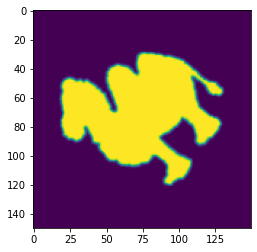

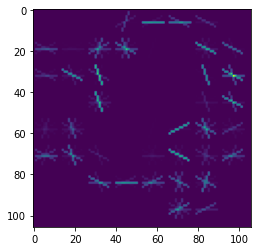

In [45]:
im = db.query("clas=='camel'").image.iloc[7]


p = (200-155)//2

params = dict(
    orientations=5,
    pixels_per_cell=(13,13),
    cells_per_block=(1,1), 
    visualize=True
    )

im_f = cv2.blur(im,(5,5))
fd, hog_image = skimage.feature.hog(im[p:-p,p:-p], **params)

print(fd.shape)
plt.imshow(im)
plt.figure()
plt.imshow(hog_image)

def hog_desc(im):
    im_f = cv2.blur(im,(5,5))
    fd, hog_image = skimage.feature.hog(im_f[p:-p,p:-p], **params)
    return fd

O descritor performa bem ao utilizar as mesmas imagens regularizadas (para os testes com hamming), chegando a precisão de 0.94 para ``top_n`` = 5 e de 0.88 para ``top_n`` = 10.

Foram escolhidos valores de 13x13 pixels por célula e células de 1x1 por bloco como base e apresentaram esses resultados. Entretanto, é possível reduzir o valor de píxels por por célula, visando obter uma maior densidade de vetores de gradientes, porém sem apresentar uma melhora significativa.

In [46]:
queries, results = test_queries(hog_desc, cosine_distance, top_n=10)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3,1.0,0.9,0.9,0.3,0.9


Average along classes: 0.90


Novamente, conforme esperado, tal descritor performa muito mal quando utilizadas as imagens variadas em rotação e escala, pois os gradientes acabam por diferir muito entre as imagens. 

In [47]:
queries, results = test_queries(hog_desc, cosine_distance, top_n=5, transform=rand_rotate)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,0.2,0.6,0.8,0.4,0.8,0.6,1.0,0.8,0.8,0.4,0.6,0.2,0.4,0.6,0.2,0.4,0.2,0.8


Average along classes: 0.54


## Usando técnicas mais robustas

## CLIP

CLIP é uma das tecnologias mais recentes e promissoras quando se trata de classificação de imagens. Baseada no aprendizado de conceitos visuais a partir de processamento natural de linguagem.

O objetivo de utilizar essa tecnologia nesse trabalho é, sobretudo, mostrar que uma tecnologia tão robusta para solução de problemas de classificação pode ser utilizada, porém apresenta resultado similar às técnicas "tradicionais" para o problema de CBIR. 

Aqui é usado um modelo treinado no dataset da imageNet, e é passado o dataset com as imagens para gerar um classificador capaz de identificar as imagens do nosso domínio. 

In [48]:
model, preprocess = clip.load("ViT-B/32", device="cpu")

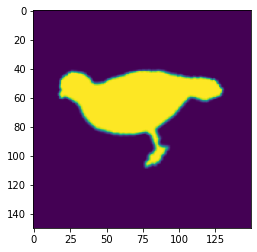

In [49]:
plt.imshow(db.image.iloc[0])
plt.show()

In [50]:
im = db.query("clas=='bird'").image.iloc[0]

In [51]:
# from PIL import Image

image = Image.fromarray(np.uint8(im))
device = "cpu"
image = preprocess(image).unsqueeze(0).to(device)
text = clip.tokenize("a " + db.clas.unique()).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[8.9605302e-01 7.3213750e-03 1.5691499e-03 5.4373294e-03 2.2067153e-03
  9.4070379e-03 1.9367954e-03 1.7990875e-03 2.2761170e-03 1.1427089e-02
  7.2305981e-04 1.2674299e-03 4.0995781e-03 8.9705419e-03 8.1828972e-03
  7.2130803e-03 1.7006645e-02 1.3102971e-02]]


In [52]:
i = np.argmax(probs)
db.clas.unique()[i]

'bird'

In [53]:
def clip_embedding(im):
    image = Image.fromarray(np.uint8(im))
    device = "cpu"
    image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features.numpy().flatten()

Utilizando o CLIP, consguimos uma precisão de 0.99 para o dataset original, comprovando a eficácia de tal ferramenta.

In [62]:
queries, results = test_queries(clip_embedding, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0


Average along classes: 0.99


## VGG 16, CNN

A VGG 16 é uma rede convolucional, também outrora referência no estado da arte no que diz respeito a classificação de imagens. Coontendo múltiplas camadas de convolução e milhões de parâmetros ao longo dessas, é outra solução robusta, trazida a nível de comparação aos outros descritores analisados durante a execução desse trabalho. 



**Definição do modelo VGG16 com pesos pré-treinados**

In [58]:
# import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

def vgg_embedding(im):
    image = Image.fromarray(np.uint8(im))
    device = "cpu"
    image = preprocess(image).unsqueeze(0).to(device)
    return vgg16.avgpool(image).numpy().ravel()

A CNN obteu um nível de precisão de 0.94, semelhante aos valores obtidos pelos descritores de Zernike, Hamming e Hog, porém apresentando uma arquitetura muito mais densa e complexa do que as simples operações matemáticas realizadas nos cálculos dos momentos das imagens.

In [59]:
queries, results = test_queries(vgg_embedding, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8


Average along classes: 0.94


A CNN não performa bem quando apresentada a imagens que diferem do domínio na qual foi treinada. Apesar de em suas camadas iniciais ela facilmente identificar as _features_ mais simples das imagens (geoemtrias simples, contornos ...), ela possui uma tendência forte ao overfitting com base nas imagens apresentadas nos treinos, sendo muito sensível a variação de rotação em imagens.

In [63]:
queries, results = test_queries(vgg_embedding, l2Dist, top_n=5, transform=rand_rotate)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,bird,bone,brick,camel,car,children,classic,elephant,face,fork,fountain,glas,hammer,heart,key,misk,ray,turtle
Accuracy,,,,,,,,,,,,,,,,,,
0,0.2,0.4,0.4,0.2,0.4,0.4,0.2,0.2,0.6,1.0,0.6,0.4,0.6,0.6,0.4,0.6,0.6,0.2


Average along classes: 0.44


Conclusão